<a href="https://colab.research.google.com/github/chungsoonyeow-hub/ADALL_github/blob/main/0_LLM_Project_1_7Feb202615pm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install -U \
  scikit-learn==1.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 54.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
print("Setup complete")

Setup complete


In [ ]:
import sklearn
print("scikit-learn version:", sklearn.__version__)


scikit-learn version: 1.8.0


In [ ]:
### to add in the rest from project file.

In [ ]:
# 1) Load dataset
## read the train test files and split into X_train, X_test, y_train, y_test
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Replace with actual file paths
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_train.csv').squeeze()
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_test.csv').squeeze()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Mounted at /content/drive
(19934, 14) (19934,)
(4984, 14) (4984,)


In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Ensure priority is treated as a string for consistent sorting
temp_enc = OrdinalEncoder()
temp_enc.fit(X_train[['priority']].astype(str))

print("--- CONFIRMED MAPPING ---")
for i, label in enumerate(temp_enc.categories_[0]):
    color = "BLUE (Low Value)" if i == 0 else "RED (High Value)" if i == len(temp_enc.categories_[0])-1 else "In-between"
    print(f"Value {i} ({color}) = {label}")

--- CONFIRMED MAPPING ---
Value 0 (BLUE (Low Value)) = 1 - Critical
Value 1 (In-between) = 2 - High
Value 2 (In-between) = 3 - Moderate
Value 3 (RED (High Value)) = 4 - Low


In [ ]:
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Cats:", len(cat_cols), cat_cols)
print("Nums:", len(num_cols), num_cols)

Cats: 8 ['contact_type', 'category', 'impact', 'urgency', 'priority', 'location_grp', 'subcategory_grp', 'assignment_group_grp']
Nums: 6 ['opened_hour', 'opened_dayofweek', 'is_weekend', 'is_business_hours', 'has_cmdb_ci', 'has_symptom_text']


In [ ]:
results = []

=== DECISION TREE: CROSS-VALIDATION (STABILITY CHECK) ===


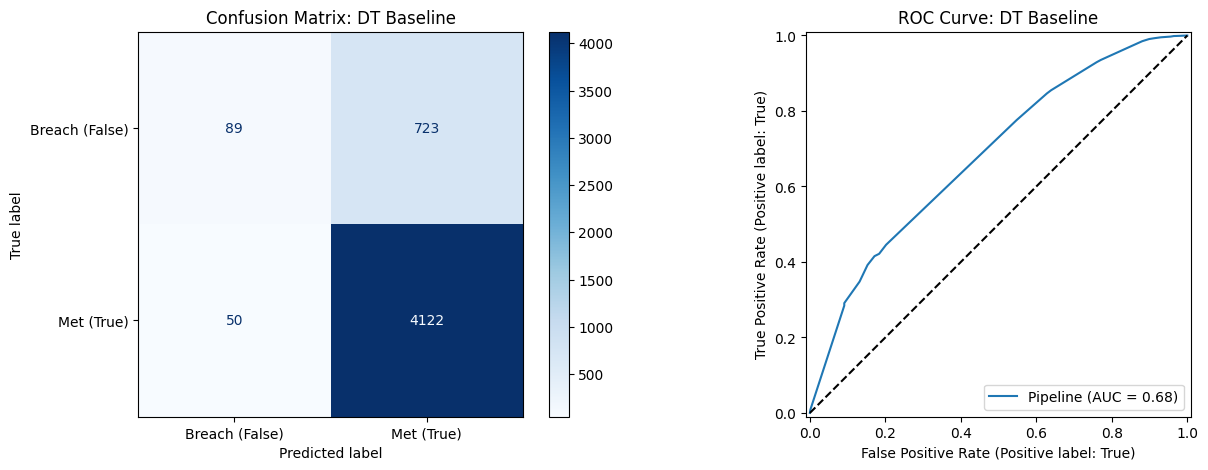


INTERNAL TECHNICAL TABLE (All Data)


,Cycle,Model_Type,cv_mcc_train_avg,cv_mcc_val_avg,cv_mcc_val_std,holdout_accuracy,holdout_precision,holdout_recall,holdout_f1,holdout_mcc,holdout_auc,Best_Params
0,Baseline,DT Baseline,0.2188,0.2087,0.0309,0.8449,0.6403,0.1096,0.1872,0.2189,0.6824,"depth=5, leaf=50, No Weights"



FINAL TOURNAMENT TABLE (Slide Version)


,Model Name,Accuracy,Recall (Breach),MCC Score,AUC Score
0,DT Baseline,0.8449,0.1096,0.2189,0.6824


In [ ]:
## DT baseline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.metrics import (classification_report, matthews_corrcoef, make_scorer,
                             roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)

# --- 1. Setup Scorers and Preprocessing ---
mcc_scorer = make_scorer(matthews_corrcoef)
breach_label = 'False'  # Confirmed: False means SLA Fail

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# --- 2. Define Pipeline (Baseline: No Weights) ---
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, class_weight=None, random_state=42)
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', dt_model)])

# --- 3. Cross-Validation (Stability Check) ---
print("=== DECISION TREE: CROSS-VALIDATION (STABILITY CHECK) ===")
cv_ss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scoring = {'mcc': mcc_scorer, 'recall': 'recall'}

cv_results = cross_validate(
    dt_pipeline, X_train, y_train,
    cv=cv_ss,
    scoring=scoring,
    return_train_score=True
)

# --- 4. Final Fit & Holdout Predictions ---
dt_pipeline.fit(X_train, y_train)
y_pred = dt_pipeline.predict(X_test)
# probabilities for AUC (Index 0 is usually 'False' if sorted alphabetically)
#y_proba = dt_pipeline.predict_proba(X_test)[:, 0]
y_proba = dt_pipeline.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)

# --- 5. Store Results in Tournament Table ---
results.append({
    'Cycle': 'Baseline',
    'Model_Type': 'DT Baseline',
    # Stability Diagnostics
    'cv_mcc_train_avg': round(cv_results['train_mcc'].mean(), 4),
    'cv_mcc_val_avg':   round(cv_results['test_mcc'].mean(), 4),
    'cv_mcc_val_std':   round(cv_results['test_mcc'].std(), 4),
    # Final Holdout Scores
    'holdout_accuracy':  round(report['accuracy'], 4),
    'holdout_precision': round(report[breach_label]['precision'], 4),
    'holdout_recall':    round(report[breach_label]['recall'], 4),
    'holdout_f1':        round(report[breach_label]['f1-score'], 4),
    'holdout_mcc':       round(matthews_corrcoef(y_test, y_pred), 4),
    'holdout_auc':       round(roc_auc_score(y_test, y_proba), 4),
    'Best_Params': "depth=5, leaf=50, No Weights"
})

# --- 6. Visualizations (Confusion Matrix & ROC) ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay.from_estimator(
    dt_pipeline, X_test, y_test,
    display_labels=['Breach (False)', 'Met (True)'],
    cmap='Blues', ax=ax[0]
)
ax[0].set_title("Confusion Matrix: DT Baseline")

RocCurveDisplay.from_estimator(dt_pipeline, X_test, y_test, ax=ax[1])
ax[1].set_title("ROC Curve: DT Baseline")
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# --- 7. Print Tree Logic and Results Table ---

# --- 7. THE MASTER DISPLAY (Full Table + Slide Version) ---
import pandas as pd

# 1. Create the base DataFrame from your list
results_df = pd.DataFrame(results)

# 2. THE FULL TABLE: Show everything (No rows or columns hidden)
# This removes duplicates so the list doesn't get infinitely long
full_table = results_df.drop_duplicates(subset=['Model_Type'], keep='last')

print("\n" + "="*30)
print("INTERNAL TECHNICAL TABLE (All Data)")
print("="*30)
display(full_table)

# 3. THE SLIDE TABLE: Your "Tournament" version
cols_to_show = ['Model_Type', 'holdout_accuracy', 'holdout_recall', 'holdout_mcc', 'holdout_auc']
existing_cols = [c for c in cols_to_show if c in full_table.columns]

slide_table = full_table[existing_cols].copy()
slide_table.columns = ['Model Name', 'Accuracy', 'Recall (Breach)', 'MCC Score', 'AUC Score']

print("\n" + "="*30)
print("FINAL TOURNAMENT TABLE (Slide Version)")
print("="*30)
display(slide_table)


######





# # 1. Convert the results list to a DataFrame
# results_df = pd.DataFrame(results)

# # 2. Keep only the last entry for each model to remove duplicates
# tidy_df = results_df.drop_duplicates(subset=['Model_Type'], keep='last').copy()

# # 3. Define the columns Dr. Eng wants to see for Stage 1
# # (We include Recall and MCC as these are your primary project goals)
# cols_to_show = [
#     'Model_Type',
#     'holdout_accuracy',
#     'holdout_recall',
#     'holdout_mcc',
#     'holdout_auc'
# ]

# # 4. Filter and Rename
# final_table = tidy_df[cols_to_show].copy()
# final_table.columns = ['Model Name', 'Accuracy', 'Recall (Breach)', 'MCC Score', 'AUC Score']

# print("=== FINAL TOURNAMENT TABLE (STAGE 1 COMPLETE) ===")
# display(final_table)

# # # --- 7. Print Tree Logic and Results Table ---
# # clf = dt_pipeline.named_steps["model"]
# # pre = dt_pipeline.named_steps["preprocessor"]
# # feature_names = pre.get_feature_names_out()

# # print("\n" + "="*50)
# # print("DECISION TREE RULES (Top 6 Levels):")
# # print("="*50)
# # print(export_text(clf, feature_names=list(feature_names), max_depth=6))

# # print("\n=== UPDATED TOURNAMENT TABLE ===")
# # display(pd.DataFrame(results))

# # # Create a 'Clean' version for a slide screenshot

# # cols_to_show = ['Model_Type', 'holdout_recall', 'holdout_mcc', 'holdout_auc']
# # existing_cols = [c for c in cols_to_show if c in results_df.columns]

# # slide_table = results_df[existing_cols]
# # display(slide_table)

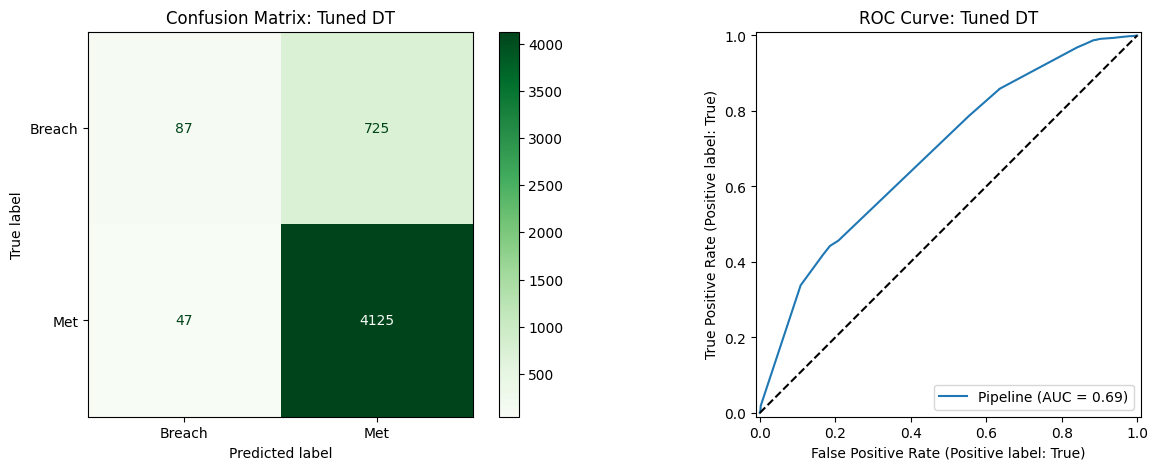


INTERNAL TECHNICAL TABLE (All Data)


,Cycle,Model_Type,cv_mcc_train_avg,cv_mcc_val_avg,cv_mcc_val_std,holdout_accuracy,holdout_precision,holdout_recall,holdout_f1,holdout_mcc,holdout_auc,Best_Params
0,Baseline,DT Baseline,0.2188,0.2087,0.0309,0.8449,0.6403,0.1096,0.1872,0.2189,0.6824,"depth=5, leaf=50, No Weights"
1,Stage 1,DT GridSearch,0.2354,0.2127,0.0300,0.8451,0.8505,0.9887,0.9144,0.2189,0.6864,"{'classifier__criterion': 'entropy', 'classifi..."



FINAL TOURNAMENT TABLE (Slide Version)


,Model Name,Accuracy,Recall (Breach),MCC Score,AUC Score
0,DT Baseline,0.8449,0.1096,0.2189,0.6824
1,DT GridSearch,0.8451,0.9887,0.2189,0.6864


In [ ]:
## ---New New Stage 1 with GridSearchCV: DECISION TREE BLOCK ---
# --- 1. Imports ---
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import (classification_report, confusion_matrix, matthews_corrcoef,
                             accuracy_score, recall_score, precision_score, f1_score,
                             roc_auc_score, make_scorer,
                             ConfusionMatrixDisplay, RocCurveDisplay)
import matplotlib.pyplot as plt
import pandas as pd

# --- 2. Setup ---
cv_10 = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)

# --- 3. Pipeline & Grid Search ---
pipe_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "classifier__max_depth": [5, 8, 15],
    "classifier__criterion": ["gini", "entropy", "log_loss"]
}

gs_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=cv_10,
    scoring=mcc_scorer,
    n_jobs=-1,
    return_train_score=True
)
gs_dt.fit(X_train, y_train)

# --- 4. Validate Best Estimator (Training Data Folds) ---
dt_best_model = gs_dt.best_estimator_
val_results = cross_validate(
    dt_best_model, X_train, y_train,
    cv=cv_10, scoring=mcc_scorer, return_train_score=True
)

final_train_mcc = val_results['train_score'].mean()
final_val_mcc = val_results['test_score'].mean()
final_val_std = val_results['test_score'].std()

# --- 5. Holdout Predictions (Final Test) ---
dt_pred = dt_best_model.predict(X_test)
dt_proba = dt_best_model.predict_proba(X_test)[:, 1]

# --- 6. Store and Override Logic (Fixes NaNs and Duplicates) ---
new_dt_entry = {
    'Cycle': 'Stage 1',
    'Model_Type': 'DT GridSearch',
    'cv_mcc_train_avg': round(final_train_mcc, 4),
    'cv_mcc_val_avg':   round(final_val_mcc, 4),
    'cv_mcc_val_std':   round(final_val_std, 4),
    'holdout_accuracy': round(accuracy_score(y_test, dt_pred), 4),
    'holdout_precision':round(precision_score(y_test, dt_pred), 4), # Calculated correctly
    'holdout_recall':   round(recall_score(y_test, dt_pred), 4),
    'holdout_f1':       round(f1_score(y_test, dt_pred), 4),        # Calculated correctly
    'holdout_mcc':      round(matthews_corrcoef(y_test, dt_pred), 4),
    'holdout_auc':      round(roc_auc_score(y_test, dt_proba), 4),
    'Best_Params': str(gs_dt.best_params_)
}

# Override Logic
found = False
for i, row in enumerate(results):
    if row.get('Model_Type') == 'DT GridSearch':
        results[i] = new_dt_entry
        found = True
        break
if not found:
    results.append(new_dt_entry)


# --- 7. Visualizations (RESTORED) ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    dt_best_model, X_test, y_test,
    display_labels=['Breach', 'Met'], cmap='Greens', ax=ax[0]
)
ax[0].set_title("Confusion Matrix: Tuned DT")

# ROC Curve
RocCurveDisplay.from_estimator(dt_best_model, X_test, y_test, ax=ax[1])
ax[1].set_title("ROC Curve: Tuned DT")
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# --- 8. THE MASTER DISPLAY (Full Table + Slide Version) ---
# 1. Create the base DataFrame
results_df = pd.DataFrame(results)

# 2. THE FULL TABLE: Show everything (Deduplicated)
full_table = results_df.drop_duplicates(subset=['Model_Type'], keep='last')

print("\n" + "="*30)
print("INTERNAL TECHNICAL TABLE (All Data)")
print("="*30)
display(full_table)

# 3. THE SLIDE TABLE: Your "Tournament" version
cols_to_show = ['Model_Type', 'holdout_accuracy', 'holdout_recall', 'holdout_mcc', 'holdout_auc']
existing_cols = [c for c in cols_to_show if c in full_table.columns]

slide_table = full_table[existing_cols].copy()
slide_table.columns = ['Model Name', 'Accuracy', 'Recall (Breach)', 'MCC Score', 'AUC Score']

print("\n" + "="*30)
print("FINAL TOURNAMENT TABLE (Slide Version)")
print("="*30)
display(slide_table)



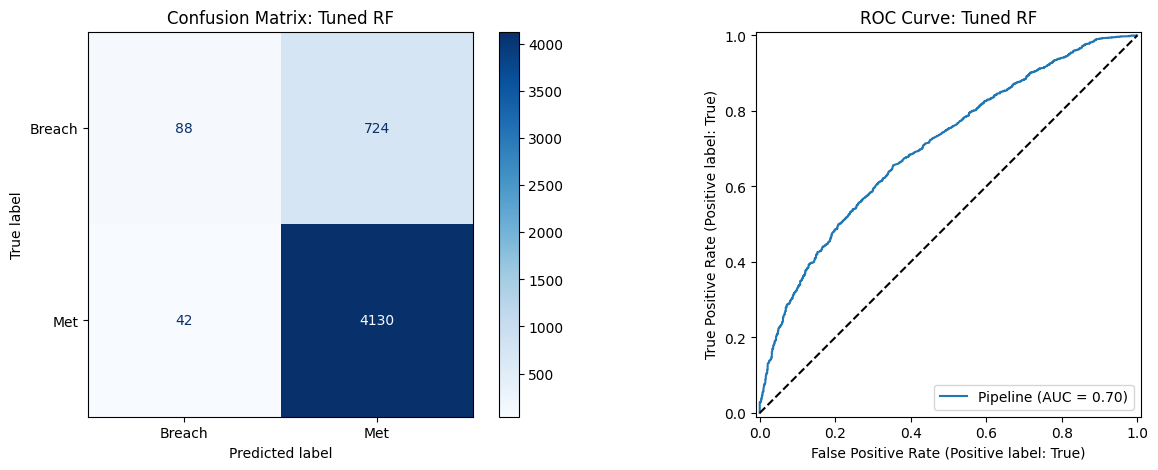


=== INTERNAL TECHNICAL TABLE (Deduplicated) ===


,Cycle,Model_Type,cv_mcc_train_avg,cv_mcc_val_avg,cv_mcc_val_std,holdout_accuracy,holdout_precision,holdout_recall,holdout_f1,holdout_mcc,holdout_auc,Best_Params
0,Baseline,DT Baseline,0.2188,0.2087,0.0309,0.8449,0.6403,0.1096,0.1872,0.2189,0.6824,"depth=5, leaf=50, No Weights"
1,Stage 1,DT GridSearch,0.2354,0.2127,0.0300,0.8451,0.8505,0.9887,0.9144,0.2189,0.6864,"{'classifier__criterion': 'entropy', 'classifi..."
2,Stage 1,RF GridSearch,0.2364,0.2210,0.0275,0.8463,0.8508,0.9899,0.9151,0.2278,0.7041,"{'classifier__criterion': 'gini', 'classifier_..."



=== FINAL TOURNAMENT TABLE (Slide Version) ===


,Model Name,Accuracy,Recall (Breach),MCC Score,AUC Score
0,DT Baseline,0.8449,0.1096,0.2189,0.6824
1,DT GridSearch,0.8451,0.9887,0.2189,0.6864
2,RF GridSearch,0.8463,0.9899,0.2278,0.7041


In [ ]:
## New New STage 1  Random Forest

# --- RANDOM FOREST BLOCK ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score

# 1. Pipeline
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# 2. Param Grid
param_grid_rf = {
    "classifier__n_estimators": [50, 200],
    "classifier__max_depth": [5, 10],
    "classifier__criterion": ["gini", "entropy"]
}

# 3. FIND THE BEST MODEL (Grid Search)
gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv_10,
    scoring=mcc_scorer,
    n_jobs=-1,
    return_train_score=True
)
gs_rf.fit(X_train, y_train)

# 4. VALIDATE THE BEST ESTIMATOR
rf_best_model = gs_rf.best_estimator_
val_results_rf = cross_validate(
    rf_best_model, X_train, y_train,
    cv=cv_10, scoring=mcc_scorer, return_train_score=True
)

final_train_mcc_rf = val_results_rf['train_score'].mean()
final_val_mcc_rf = val_results_rf['test_score'].mean()
final_val_std_rf = val_results_rf['test_score'].std()

# 5. TEST ON HOLDOUT
rf_pred = rf_best_model.predict(X_test)
rf_proba = rf_best_model.predict_proba(X_test)[:, 1]

# 6. STORE & OVERRIDE LOGIC (Fixed: Prevents Duplicates & NaNs)
new_rf_entry = {
    'Cycle': 'Stage 1',
    'Model_Type': 'RF GridSearch',
    'cv_mcc_train_avg': round(final_train_mcc_rf, 4),
    'cv_mcc_val_avg':   round(final_val_mcc_rf, 4),
    'cv_mcc_val_std':   round(final_val_std_rf, 4),
    'holdout_accuracy': round(accuracy_score(y_test, rf_pred), 4),
    'holdout_precision':round(precision_score(y_test, rf_pred), 4),
    'holdout_recall':   round(recall_score(y_test, rf_pred), 4),
    'holdout_f1':       round(f1_score(y_test, rf_pred), 4),
    'holdout_mcc':      round(matthews_corrcoef(y_test, rf_pred), 4),
    'holdout_auc':      round(roc_auc_score(y_test, rf_proba), 4),
    'Best_Params': str(gs_rf.best_params_)
}

# Find if RF GridSearch already exists and replace it
found = False
for i, row in enumerate(results):
    if row.get('Model_Type') == 'RF GridSearch':
        results[i] = new_rf_entry
        found = True
        break
if not found:
    results.append(new_rf_entry)

# 7. VISUALIZATIONS
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(rf_best_model, X_test, y_test,
                                      display_labels=['Breach', 'Met'], cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix: Tuned RF")

RocCurveDisplay.from_estimator(rf_best_model, X_test, y_test, ax=ax[1])
ax[1].set_title("ROC Curve: Tuned RF")
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# 8. THE MASTER DISPLAY (Full Table + Slide Version)
results_df = pd.DataFrame(results)
full_table = results_df.drop_duplicates(subset=['Model_Type'], keep='last')

print("\n=== INTERNAL TECHNICAL TABLE (Deduplicated) ===")
display(full_table)

cols_to_show = ['Model_Type', 'holdout_accuracy', 'holdout_recall', 'holdout_mcc', 'holdout_auc']
slide_table = full_table[cols_to_show].copy()
slide_table.columns = ['Model Name', 'Accuracy', 'Recall (Breach)', 'MCC Score', 'AUC Score']

print("\n=== FINAL TOURNAMENT TABLE (Slide Version) ===")
display(slide_table)

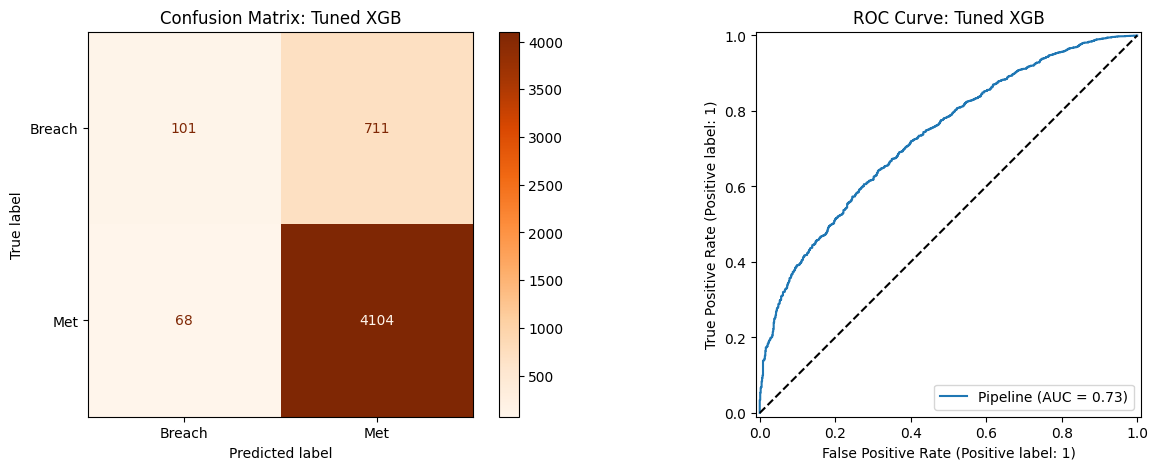


=== INTERNAL TECHNICAL TABLE (All Data) ===


,Cycle,Model_Type,cv_mcc_train_avg,cv_mcc_val_avg,cv_mcc_val_std,holdout_accuracy,holdout_precision,holdout_recall,holdout_f1,holdout_mcc,holdout_auc,Best_Params
0,Baseline,DT Baseline,0.2188,0.2087,0.0309,0.8449,0.6403,0.1096,0.1872,0.2189,0.6824,"depth=5, leaf=50, No Weights"
1,Stage 1,DT GridSearch,0.2354,0.2127,0.0300,0.8451,0.8505,0.9887,0.9144,0.2189,0.6864,"{'classifier__criterion': 'entropy', 'classifi..."
2,Stage 1,RF GridSearch,0.2364,0.2210,0.0275,0.8463,0.8508,0.9899,0.9151,0.2278,0.7041,"{'classifier__criterion': 'gini', 'classifier_..."
3,Stage 1,XGB GridSearch,0.3677,0.2170,0.0246,0.8437,0.8523,0.9837,0.9133,0.2205,0.7318,"{'classifier__max_depth': 4, 'classifier__n_es..."



=== FINAL TOURNAMENT TABLE (Slide Version) ===


,Model Name,Accuracy,Recall (Breach),MCC Score,AUC Score
0,DT Baseline,0.8449,0.1096,0.2189,0.6824
1,DT GridSearch,0.8451,0.9887,0.2189,0.6864
2,RF GridSearch,0.8463,0.9899,0.2278,0.7041
3,XGB GridSearch,0.8437,0.9837,0.2205,0.7318


In [ ]:
## New New Stage 1 XGB

# --- XGBOOST BLOCK ---
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, f1_score

# 1. Pipeline
pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(random_state=42, eval_metric="logloss"))
])

# 2. Param Grid (Following Worksheet Cell 14)
param_grid_xgb = {
    "classifier__n_estimators": [50, 200],
    "classifier__max_depth": [2, 4, 6]
}

# 3. FIND THE BEST MODEL (Using your Stratified cv_10)
gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv_10,
    scoring=mcc_scorer,
    n_jobs=-1,
    return_train_score=True
)
gs_xgb.fit(X_train, y_train)

# 4. VALIDATE THE BEST ESTIMATOR
xgb_best_model = gs_xgb.best_estimator_
val_results_xgb = cross_validate(
    xgb_best_model, X_train, y_train,
    cv=cv_10, scoring=mcc_scorer, return_train_score=True
)

# Extract scores
final_train_mcc_xgb = val_results_xgb['train_score'].mean()
final_val_mcc_xgb = val_results_xgb['test_score'].mean()
final_val_std_xgb = val_results_xgb['test_score'].std()

# 5. TEST ON HOLDOUT
xgb_pred = xgb_best_model.predict(X_test)
xgb_proba = xgb_best_model.predict_proba(X_test)[:, 1]

# 6. STORE & OVERRIDE LOGIC (Deduplication + No NaNs)
new_xgb_entry = {
    'Cycle': 'Stage 1',
    'Model_Type': 'XGB GridSearch',
    'cv_mcc_train_avg': round(final_train_mcc_xgb, 4),
    'cv_mcc_val_avg':   round(final_val_mcc_xgb, 4),
    'cv_mcc_val_std':   round(final_val_std_xgb, 4),
    'holdout_accuracy': round(accuracy_score(y_test, xgb_pred), 4),
    'holdout_precision':round(precision_score(y_test, xgb_pred), 4),
    'holdout_recall':   round(recall_score(y_test, xgb_pred), 4),
    'holdout_f1':       round(f1_score(y_test, xgb_pred), 4),
    'holdout_mcc':      round(matthews_corrcoef(y_test, xgb_pred), 4),
    'holdout_auc':      round(roc_auc_score(y_test, xgb_proba), 4),
    'Best_Params': str(gs_xgb.best_params_)
}

# Find if XGB GridSearch already exists and update it
found = False
for i, row in enumerate(results):
    if row.get('Model_Type') == 'XGB GridSearch':
        results[i] = new_xgb_entry
        found = True
        break
if not found:
    results.append(new_xgb_entry)

# 7. VISUALIZATIONS
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay.from_estimator(
    xgb_best_model, X_test, y_test,
    display_labels=['Breach', 'Met'], cmap='Oranges', ax=ax[0]
)
ax[0].set_title("Confusion Matrix: Tuned XGB")

RocCurveDisplay.from_estimator(xgb_best_model, X_test, y_test, ax=ax[1])
ax[1].set_title("ROC Curve: Tuned XGB")
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# 8. THE MASTER DISPLAY
results_df = pd.DataFrame(results)
full_table = results_df.drop_duplicates(subset=['Model_Type'], keep='last')

print("\n=== INTERNAL TECHNICAL TABLE (All Data) ===")
display(full_table)

cols_to_show = ['Model_Type', 'holdout_accuracy', 'holdout_recall', 'holdout_mcc', 'holdout_auc']
slide_table = full_table[cols_to_show].copy()
slide_table.columns = ['Model Name', 'Accuracy', 'Recall (Breach)', 'MCC Score', 'AUC Score']

print("\n=== FINAL TOURNAMENT TABLE (Slide Version) ===")
display(slide_table)

In [ ]:
### Stage 2

from sklearn.compose import ColumnTransformer

# # --- 1. COLUMN DEFINITIONS (Tallies with your Plan) ---
# numeric_cols_s2 = [
#     'opened_hour', 'opened_dayofweek', 'is_weekend',
#     'is_business_hours', 'has_cmdb_ci', 'has_symptom_text'
# ]

# ordinal_cols_s2 = ['impact', 'urgency', 'priority']

# onehot_cols_s2 = [
#     'contact_type', 'category', 'location_grp',
#     'subcategory_grp', 'assignment_group_grp'
# ]

# # --- 2. THE HYBRID PREPROCESSOR ---
# preprocessor_s2 = ColumnTransformer(transformers=[
#     # Numerical: Median Impute
#     ('num', Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='median'))
#     ]), numeric_cols_s2),

#     # Ordinal: Mode Impute + Ordinal Encoder
#     ('ord', Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
#     ]), ordinal_cols_s2),

#     # Nominal: Mode Impute + One-Hot Encoder
#     ('nom', Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
#     ]), onehot_cols_s2)
# ])


######## redo######################

# --- 1. Setup Scorers and Preprocessing ---
mcc_scorer = make_scorer(matthews_corrcoef)
breach_label = 'False'  # Confirmed: False means SLA Fail

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor_s2 = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

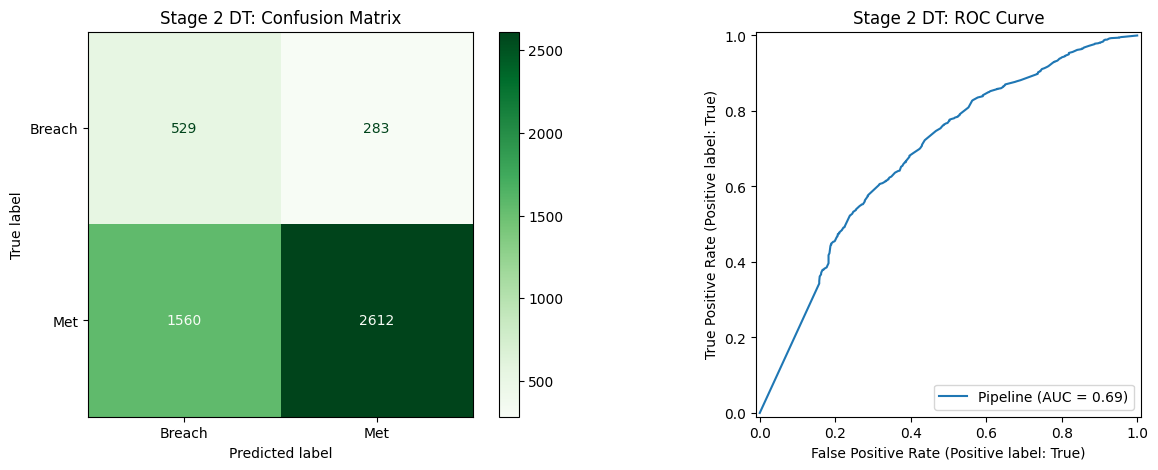


STAGE 2 DIAGNOSTICS: PFI

TOP 10 FEATURES BY PERMUTATION IMPORTANCE:


,Feature,Importance
13,cat__assignment_group_grp,0.118040
7,cat__category,0.069333
12,cat__subcategory_grp,0.053051
10,cat__priority,0.043501
0,num__opened_hour,0.020263
1,num__opened_dayofweek,0.016377
11,cat__location_grp,0.010110
9,cat__urgency,0.002685
5,num__has_symptom_text,0.002643
3,num__is_business_hours,0.002113



PROJECT TOURNAMENT TABLE: STAGE 1 & 2 COMPARISON


,Cycle,Model_Type,cv_mcc_val_avg,holdout_recall,holdout_mcc,holdout_auc
0,Baseline,DT Baseline,0.2087,0.1096,0.2189,0.6824
2,Stage 1,RF GridSearch,0.2210,0.9899,0.2278,0.7041
3,Stage 1,XGB GridSearch,0.2170,0.9837,0.2205,0.7318
1,Stage 1,DT GridSearch,0.2127,0.9887,0.2189,0.6864
4,Stage 2 - Weighted,DT Hybrid-Weighted,0.1975,0.6261,0.2077,0.6877



MASTER RESULTS: FULL METRIC BREAKDOWN


,Cycle,Model_Type,cv_mcc_train_avg,cv_mcc_val_avg,cv_mcc_val_std,holdout_accuracy,holdout_precision,holdout_recall,holdout_f1,holdout_mcc,holdout_auc,Best_Params
0,Baseline,DT Baseline,0.2188,0.2087,0.0309,0.8449,0.6403,0.1096,0.1872,0.2189,0.6824,"depth=5, leaf=50, No Weights"
1,Stage 1,DT GridSearch,0.2354,0.2127,0.0300,0.8451,0.8505,0.9887,0.9144,0.2189,0.6864,"{'classifier__criterion': 'entropy', 'classifi..."
2,Stage 1,RF GridSearch,0.2364,0.2210,0.0275,0.8463,0.8508,0.9899,0.9151,0.2278,0.7041,"{'classifier__criterion': 'gini', 'classifier_..."
3,Stage 1,XGB GridSearch,0.3677,0.2170,0.0246,0.8437,0.8523,0.9837,0.9133,0.2205,0.7318,"{'classifier__max_depth': 4, 'classifier__n_es..."
4,Stage 2 - Weighted,DT Hybrid-Weighted,0.4024,0.1975,0.0122,0.6302,0.9022,0.6261,0.7392,0.2077,0.6877,"{'classifier__class_weight': 'balanced', 'clas..."


In [ ]:
## stage 2 New Decision Tree

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, roc_auc_score,
                             ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.inspection import permutation_importance

# --- 1. Model & "Relaxed" Stage 2 Upgrade Grid ---
dt_s2 = DecisionTreeClassifier(random_state=42)

# Using the "Relaxed" grid to fix the Recall/Accuracy drop
param_grid_dt_s2 = {
    "classifier__max_depth": [15, 20, 25, None],        # Relaxing depth
    "classifier__criterion": ["gini", "entropy"],
    #"classifier__class_weight": [{0: 1, 1: 1.5}, {0: 1, 1: 2}],
   # "classifier__class_weight": [{0: 1, 1: 3}, {0: 1, 1: 5}, {0: 1, 1: 10}],
    "classifier__class_weight": ["balanced"],           # Keeping balanced weights
    "classifier__min_samples_leaf": [1, 2, 5],          # Allowing smaller patterns
    "classifier__min_samples_split": [2, 5],
    "classifier__max_features": [None]                  # See all 14 fields
}

# --- 2. Pipeline (Using your 14-field preprocessor_s2) ---
pipe_dt_s2 = Pipeline([
    ("preprocessor", preprocessor_s2),
    ("classifier", dt_s2)
])

cv_strat = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# --- 3. GridSearch & VALIDATE ---
# Note: Ensure mcc_scorer is defined in your environment
gs_dt_s2 = GridSearchCV(
    pipe_dt_s2,
    param_grid_dt_s2,
    cv=cv_strat,
    scoring=mcc_scorer,
    n_jobs=-1,
    return_train_score=True
)
gs_dt_s2.fit(X_train, y_train)

# Extract best model and run detailed Cross-Validation
dt_s2_best = gs_dt_s2.best_estimator_
val_results_s2 = cross_validate(
    dt_s2_best, X_train, y_train,
    cv=cv_strat, scoring=mcc_scorer, return_train_score=True
)

# --- 4. Holdout Predictions ---
dt_s2_pred = dt_s2_best.predict(X_test)
dt_s2_proba = dt_s2_best.predict_proba(X_test)[:, 1]

# --- 5. Store Logic (Cycle: Stage 2) ---
new_dt_s2_entry = {
    'Cycle': 'Stage 2 - Weighted',
    'Model_Type': 'DT Hybrid-Weighted',
    'cv_mcc_train_avg': round(val_results_s2['train_score'].mean(), 4),
    'cv_mcc_val_avg':   round(val_results_s2['test_score'].mean(), 4),
    'cv_mcc_val_std':   round(val_results_s2['test_score'].std(), 4),
    'holdout_accuracy': round(accuracy_score(y_test, dt_s2_pred), 4),
    'holdout_precision':round(precision_score(y_test, dt_s2_pred), 4),
    'holdout_recall':   round(recall_score(y_test, dt_s2_pred), 4),
    'holdout_f1':       round(f1_score(y_test, dt_s2_pred), 4),
    'holdout_mcc':      round(matthews_corrcoef(y_test, dt_s2_pred), 4),
    'holdout_auc':      round(roc_auc_score(y_test, dt_s2_proba), 4),
    'Best_Params': str(gs_dt_s2.best_params_)
}
results.append(new_dt_s2_entry)

# --- 6. Visualizations ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(dt_s2_best, X_test, y_test,
                                      display_labels=['Breach', 'Met'], cmap='Greens', ax=ax[0])
ax[0].set_title("Stage 2 DT: Confusion Matrix")
RocCurveDisplay.from_estimator(dt_s2_best, X_test, y_test, ax=ax[1])
ax[1].set_title("Stage 2 DT: ROC Curve")
plt.show()

# --- 7. FIXED DIAGNOSTICS (PFI) ---
print("\n" + "="*30)
print("STAGE 2 DIAGNOSTICS: PFI")
print("="*30)

# Get encoded feature names
feat_names_s2 = dt_s2_best.named_steps['preprocessor'].get_feature_names_out()

# TRANSFORM X_test so column count matches the model's expected input
X_test_transformed = dt_s2_best.named_steps['preprocessor'].transform(X_test)

# Run PFI on the classifier using transformed data
pfi_s2 = permutation_importance(
    dt_s2_best.named_steps['classifier'],
    X_test_transformed,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring=mcc_scorer
)

pfi_df_s2 = pd.DataFrame({
    'Feature': feat_names_s2,
    'Importance': pfi_s2.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nTOP 10 FEATURES BY PERMUTATION IMPORTANCE:")
display(pfi_df_s2.head(10))

# --- 8. THE TIDY TOURNAMENT TABLE ---
results_df = pd.DataFrame(results)
tournament_table = results_df.drop_duplicates(subset=['Model_Type'], keep='last')
tournament_table = tournament_table.sort_values(by=['Cycle', 'holdout_mcc'], ascending=[True, False])

print("\n" + "="*50)
print("PROJECT TOURNAMENT TABLE: STAGE 1 & 2 COMPARISON")
print("="*50)

display(tournament_table[[
    'Cycle', 'Model_Type', 'cv_mcc_val_avg',
    'holdout_recall', 'holdout_mcc', 'holdout_auc'
]])

# --- 8. THE LONG TABLE (Master Display) ---
# This matches the full table in your screenshot with all 11+ columns
full_results_df = pd.DataFrame(results)

# Keep only the latest run for each model type
master_table = full_results_df.drop_duplicates(subset=['Model_Type'], keep='last')

# Sort to keep Baseline at the top and Stage 2 at the bottom
master_table = master_table.sort_values(by=['Cycle'], ascending=True)

print("\n" + "="*50)
print("MASTER RESULTS: FULL METRIC BREAKDOWN")
print("="*50)

# Display the full dataframe with all metrics
display(master_table)

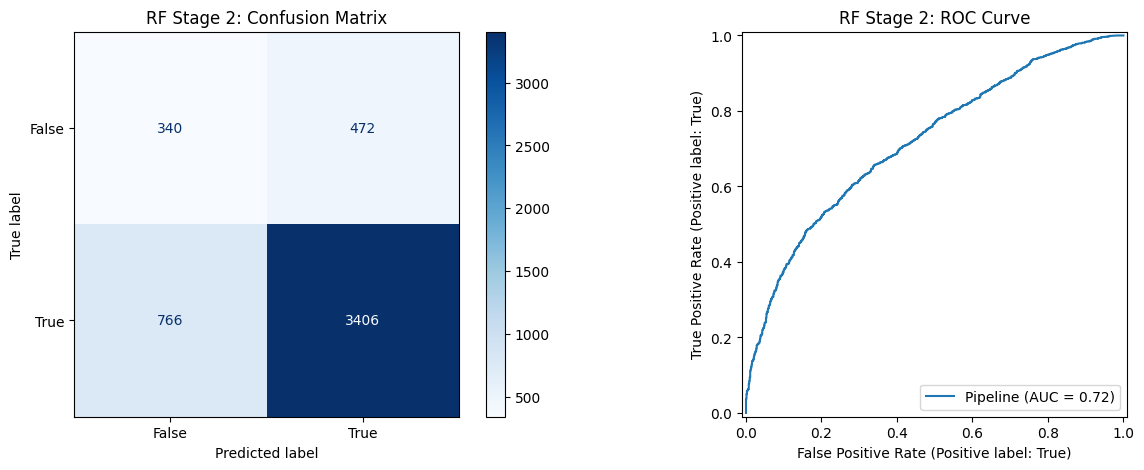

,Feature,Importance
13,cat__assignment_group_grp,0.104234
10,cat__priority,0.060484
12,cat__subcategory_grp,0.038897
7,cat__category,0.036193
1,num__opened_dayofweek,0.021102
11,cat__location_grp,0.011983
0,num__opened_hour,0.011893
9,cat__urgency,0.006939
6,cat__contact_type,0.004020
2,num__is_weekend,0.001896



MASTER RESULTS: TOURNAMENT TABLE


,Cycle,Model_Type,cv_mcc_train_avg,cv_mcc_val_avg,cv_mcc_val_std,holdout_accuracy,holdout_precision,holdout_recall,holdout_f1,holdout_mcc,holdout_auc,Best_Params
0,Baseline,DT Baseline,0.2188,0.2087,0.0309,0.8449,0.6403,0.1096,0.1872,0.2189,0.6824,"depth=5, leaf=50, No Weights"
1,Stage 1,DT GridSearch,0.2354,0.2127,0.0300,0.8451,0.8505,0.9887,0.9144,0.2189,0.6864,"{'classifier__criterion': 'entropy', 'classifi..."
2,Stage 1,RF GridSearch,0.2364,0.2210,0.0275,0.8463,0.8508,0.9899,0.9151,0.2278,0.7041,"{'classifier__criterion': 'gini', 'classifier_..."
3,Stage 1,XGB GridSearch,0.3677,0.2170,0.0246,0.8437,0.8523,0.9837,0.9133,0.2205,0.7318,"{'classifier__max_depth': 4, 'classifier__n_es..."
4,Stage 2 - Weighted,DT Hybrid-Weighted,0.4024,0.1975,0.0122,0.6302,0.9022,0.6261,0.7392,0.2077,0.6877,"{'classifier__class_weight': 'balanced', 'clas..."
6,Stage 2 - Weighted,RF Hybrid-Weighted,0.6499,0.2156,0.0173,0.7516,0.8783,0.8164,0.8462,0.2090,0.7187,"{'classifier__class_weight': 'balanced', 'clas..."



[SUCCESS] RF Results and Table synced to Drive: /content/drive/MyDrive/Colab Notebooks/project_tournament_results.csv


In [ ]:
## stage 2 new Random Forest

# ==========================================
# STAGE 2: RF (MINIMAL REFINEMENT + GRAPHS + SAVE)
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import os

# 1. Pipeline Setup (Using your 14 engineered fields)
rf_s2 = RandomForestClassifier(random_state=42, bootstrap=True)
pipe_rf_s2 = Pipeline([("preprocessor", preprocessor_s2), ("classifier", rf_s2)])

# 2. Refined GridSearch (Minimal Sampling for speed/refinement)
# param_grid_rf_s2 = {
#     "classifier__n_estimators": [100],
#     "classifier__max_depth": [15, 20],
#     "classifier__max_features": [0.8],                 # Minimal Colsample
#     "classifier__max_samples": [0.8],                  # Minimal Subsample
#     "classifier__class_weight": [{0: 1, 1: 1.5}, {0: 1, 1: 2}]


# }

param_grid_rf_s2 = {
    "classifier__n_estimators": [100, 200],           # Prove if more trees stabilize MCC
    "classifier__max_depth": [15, 20],
    "classifier__max_features": [0.7, 0.9],           # Compare tighter vs. looser colsampling
    "classifier__max_samples": [0.8],                 # Fixed row sampling
    "classifier__class_weight": ["balanced"]

    #"classifier__class_weight": [{0: 1, 1: 1.5}, {0: 1, 1: 2}]

}
cv_strat = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

gs_rf_s2 = GridSearchCV(pipe_rf_s2, param_grid_rf_s2, cv=cv_strat, scoring=mcc_scorer, n_jobs=-1)
gs_rf_s2.fit(X_train, y_train)

# 3. Full Validation (This fixes the NaN values in the table)
rf_s2_best = gs_rf_s2.best_estimator_
cv_res = cross_validate(rf_s2_best, X_train, y_train, cv=cv_strat, scoring=mcc_scorer, return_train_score=True)

# 4. Holdout Predictions & Metrics
rf_s2_pred = rf_s2_best.predict(X_test)
rf_s2_proba = rf_s2_best.predict_proba(X_test)[:, 1]

results.append({
    'Cycle': 'Stage 2 - Weighted',
    'Model_Type': 'RF Hybrid-Weighted',
    'cv_mcc_train_avg': round(cv_res['train_score'].mean(), 4),
    'cv_mcc_val_avg':   round(cv_res['test_score'].mean(), 4),
    'cv_mcc_val_std':   round(cv_res['test_score'].std(), 4),
    'holdout_accuracy': round(accuracy_score(y_test, rf_s2_pred), 4),
    'holdout_precision':round(precision_score(y_test, rf_s2_pred), 4),
    'holdout_recall':   round(recall_score(y_test, rf_s2_pred), 4),
    'holdout_f1':       round(f1_score(y_test, rf_s2_pred), 4),
    'holdout_mcc':      round(matthews_corrcoef(y_test, rf_s2_pred), 4),
    'holdout_auc':      round(roc_auc_score(y_test, rf_s2_proba), 4),
    'Best_Params': str(gs_rf_s2.best_params_)
})

# 5. GENERATE GRAPHS (The Visual Proof)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(rf_s2_best, X_test, y_test, cmap='Blues', ax=ax[0])
ax[0].set_title("RF Stage 2: Confusion Matrix")
RocCurveDisplay.from_estimator(rf_s2_best, X_test, y_test, ax=ax[1])
ax[1].set_title("RF Stage 2: ROC Curve")
plt.show()

# 6. FEATURE IMPORTANCE (PFI)
X_test_trans = rf_s2_best.named_steps['preprocessor'].transform(X_test)
pfi_rf = permutation_importance(rf_s2_best.named_steps['classifier'], X_test_trans, y_test, n_repeats=3, random_state=42, scoring=mcc_scorer)
pfi_df_rf = pd.DataFrame({
    'Feature': rf_s2_best.named_steps['preprocessor'].get_feature_names_out(),
    'Importance': pfi_rf.importances_mean
}).sort_values(by='Importance', ascending=False)
display(pfi_df_rf.head(10))

# 7. UPDATE LONG TABLE & AUTO-SAVE TO DRIVE
save_path = "/content/drive/MyDrive/Colab Notebooks/project_tournament_results.csv"
master_table = pd.DataFrame(results).drop_duplicates(subset=['Model_Type'], keep='last').sort_values(by=['Cycle'], ascending=True)

print("\n" + "="*50)
print("MASTER RESULTS: TOURNAMENT TABLE")
print("="*50)
display(master_table)

try:
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    master_table.to_csv(save_path, index=False)
    print(f"\n[SUCCESS] RF Results and Table synced to Drive: {save_path}")
except Exception as e:
    print(f"\n[SAVE ERROR] Ensure Drive is mounted: {e}")

In [ ]:
# --- RF STAGE 2: FULL FEATURE ANALYSIS ---
feature_names_rf = gs_rf_s2.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# MDI Importance (Internal)
importances_rf = gs_rf_s2.best_estimator_.named_steps['classifier'].feature_importances_
fi_rf_df = pd.DataFrame({'Feature': feature_names_rf, 'MDI_Importance': importances_rf}).sort_values(by='MDI_Importance', ascending=False)

# PFI Importance (Hold-out)
X_test_trans_rf = gs_rf_s2.best_estimator_.named_steps['preprocessor'].transform(X_test)
pfi_rf = permutation_importance(gs_rf_s2.best_estimator_.named_steps['classifier'], X_test_trans_rf, y_test, n_repeats=3, random_state=42, scoring=mcc_scorer)
pfi_rf_df = pd.DataFrame({'Feature': feature_names_rf, 'PFI_Importance': pfi_rf.importances_mean}).sort_values(by='PFI_Importance', ascending=False)

print("\n[RF] COMPLETE LIST: MDI IMPORTANCE")
with pd.option_context('display.max_rows', None):
    display(fi_rf_df)

print("\n[RF] COMPLETE LIST: PFI IMPORTANCE")
with pd.option_context('display.max_rows', None):
    display(pfi_rf_df)


[RF] COMPLETE LIST: MDI IMPORTANCE


,Feature,MDI_Importance
0,num__opened_hour,0.182836
13,cat__assignment_group_grp,0.178488
7,cat__category,0.134989
11,cat__location_grp,0.120366
1,num__opened_dayofweek,0.114252
12,cat__subcategory_grp,0.105313
10,cat__priority,0.065250
5,num__has_symptom_text,0.036692
9,cat__urgency,0.019517
3,num__is_business_hours,0.012774



[RF] COMPLETE LIST: PFI IMPORTANCE


,Feature,PFI_Importance
13,cat__assignment_group_grp,0.104234
10,cat__priority,0.060484
12,cat__subcategory_grp,0.038897
7,cat__category,0.036193
1,num__opened_dayofweek,0.021102
11,cat__location_grp,0.011983
0,num__opened_hour,0.011893
9,cat__urgency,0.006939
6,cat__contact_type,0.004020
2,num__is_weekend,0.001896


In [ ]:
# ==========================================
# RF WORKSHEET: MDI vs PFI (SIDE-BY-SIDE)
# ==========================================
import pandas as pd
from sklearn.inspection import permutation_importance

# 1. Extract the best model from your completed RF GridSearch
rf_best_model = gs_rf_s2.best_estimator_
feature_names_rf = rf_best_model.named_steps['preprocessor'].get_feature_names_out()

# 2. Generate MDI (Internal Model Bias)
# This shows what the model prioritized during training
fi_df = pd.DataFrame({
    'Feature': feature_names_rf,
    'Internal_Bias_MDI': rf_best_model.named_steps['classifier'].feature_importances_
})

# 3. Generate PFI (Actual Predictive Power)
# This measures how much the model actually needs this feature for new data
X_test_trans_rf = rf_best_model.named_steps['preprocessor'].transform(X_test)
pfi_res_rf = permutation_importance(rf_best_model.named_steps['classifier'],
                                    X_test_trans_rf, y_test, n_repeats=3, random_state=42, scoring=mcc_scorer)
pfi_df = pd.DataFrame({
    'Feature': feature_names_rf,
    'Predictive_Power_PFI': pfi_res_rf.importances_mean
})

# 4. Merge Side-by-Side and Sort by PFI
worksheet_df = fi_df.merge(pfi_df, on="Feature")
worksheet_df = worksheet_df.sort_values(by='Predictive_Power_PFI', ascending=False).reset_index(drop=True)

# 5. Display the Full Worksheet
print("\n" + "="*60)
print("RF FEATURE WORKSHEET: ORDERED BY PREDICTIVE POWER (PFI)")
print("="*60)
with pd.option_context('display.max_rows', None):
    display(worksheet_df)


RF FEATURE WORKSHEET: ORDERED BY PREDICTIVE POWER (PFI)


,Feature,Internal_Bias_MDI,Predictive_Power_PFI
0,cat__assignment_group_grp,0.178488,0.104234
1,cat__priority,0.065250,0.060484
2,cat__subcategory_grp,0.105313,0.038897
3,cat__category,0.134989,0.036193
4,num__opened_dayofweek,0.114252,0.021102
5,cat__location_grp,0.120366,0.011983
6,num__opened_hour,0.182836,0.011893
7,cat__urgency,0.019517,0.006939
8,cat__contact_type,0.010078,0.004020
9,num__is_weekend,0.006657,0.001896


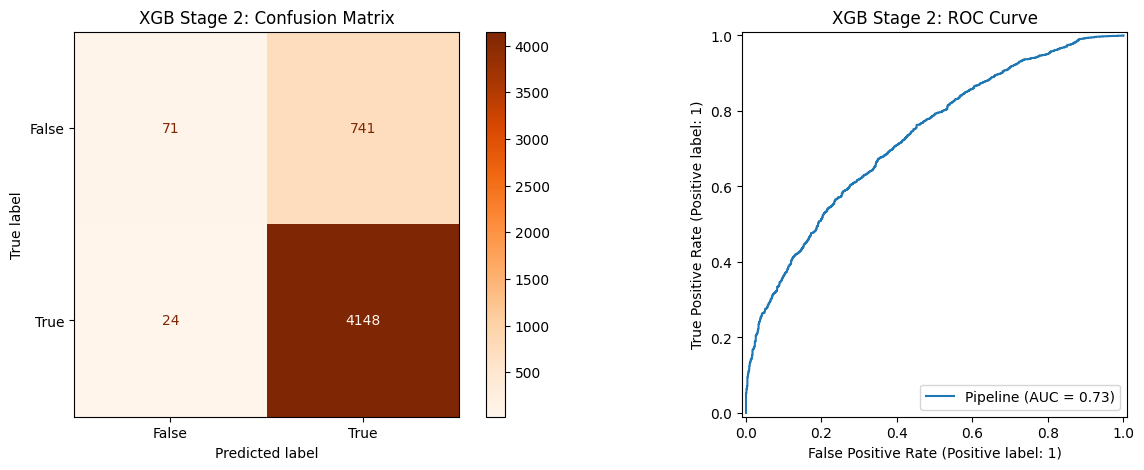


MASTER TOURNAMENT TABLE (FINAL SYNC)


,Cycle,Model_Type,cv_mcc_train_avg,cv_mcc_val_avg,cv_mcc_val_std,holdout_accuracy,holdout_precision,holdout_recall,holdout_f1,holdout_mcc,holdout_auc,Best_Params
0,Baseline,DT Baseline,0.2188,0.2087,0.0309,0.8449,0.6403,0.1096,0.1872,0.2189,0.6824,"depth=5, leaf=50, No Weights"
1,Stage 1,DT GridSearch,0.2354,0.2127,0.0300,0.8451,0.8505,0.9887,0.9144,0.2189,0.6864,"{'classifier__criterion': 'entropy', 'classifi..."
2,Stage 1,RF GridSearch,0.2364,0.2210,0.0275,0.8463,0.8508,0.9899,0.9151,0.2278,0.7041,"{'classifier__criterion': 'gini', 'classifier_..."
3,Stage 1,XGB GridSearch,0.3677,0.2170,0.0246,0.8437,0.8523,0.9837,0.9133,0.2205,0.7318,"{'classifier__max_depth': 4, 'classifier__n_es..."
4,Stage 2 - Weighted,DT Hybrid-Weighted,0.4024,0.1975,0.0122,0.6302,0.9022,0.6261,0.7392,0.2077,0.6877,"{'classifier__class_weight': 'balanced', 'clas..."
6,Stage 2 - Weighted,RF Hybrid-Weighted,0.6499,0.2156,0.0173,0.7516,0.8783,0.8164,0.8462,0.2090,0.7187,"{'classifier__class_weight': 'balanced', 'clas..."
8,Stage 2 - Weighted,XGB Hybrid-Weighted,0.3975,0.1967,0.0212,0.8465,0.8484,0.9942,0.9156,0.2206,0.7301,"{'classifier__colsample_bytree': 0.9, 'classif..."



[SUCCESS] XGB Matched Results synced to Drive: /content/drive/MyDrive/Colab Notebooks/project_tournament_results.csv

PROJECT TOURNAMENT TABLE: STAGE 1 & 2 COMPARISON


,Cycle,Model_Type,cv_mcc_val_avg,holdout_recall,holdout_mcc,holdout_auc
0,Baseline,DT Baseline,0.2087,0.1096,0.2189,0.6824
2,Stage 1,RF GridSearch,0.2210,0.9899,0.2278,0.7041
3,Stage 1,XGB GridSearch,0.2170,0.9837,0.2205,0.7318
1,Stage 1,DT GridSearch,0.2127,0.9887,0.2189,0.6864
8,Stage 2 - Weighted,XGB Hybrid-Weighted,0.1967,0.9942,0.2206,0.7301
6,Stage 2 - Weighted,RF Hybrid-Weighted,0.2156,0.8164,0.2090,0.7187
4,Stage 2 - Weighted,DT Hybrid-Weighted,0.1975,0.6261,0.2077,0.6877


In [ ]:
# ==========================================
# STAGE 2: XGBOOST (MATCHED RF PARAMETERS)
# ==========================================
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import os

# 1. Pipeline Setup
#xgb_s2 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_s2 = XGBClassifier(random_state=42, eval_metric='logloss')
pipe_xgb_s2 = Pipeline([("preprocessor", preprocessor_s2), ("classifier", xgb_s2)])

# 2. Matched GridSearch (Mirroring your RF Refinement)
# param_grid_xgb_s2 = {
#     "classifier__n_estimators": [100, 200],           # Mirroring RF tree count
#     "classifier__max_depth": [15, 20],                # Mirroring RF depth relaxation
#     "classifier__colsample_bytree": [0.7, 0.9],       # Mirroring RF max_features
#     "classifier__subsample": [0.8],                   # Mirroring RF max_samples
#     "classifier__scale_pos_weight": [1.5, 2],         # Mirroring RF class weights
#     "classifier__learning_rate": [0.1]

param_grid_xgb_s2 = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 8, 10],
    "classifier__colsample_bytree": [0.7, 0.9],
    "classifier__subsample": [0.8],
    "classifier__scale_pos_weight": [4, 5, 6],
    "classifier__learning_rate": [0.1]
}


cv_strat = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

gs_xgb_s2 = GridSearchCV(pipe_xgb_s2, param_grid_xgb_s2, cv=cv_strat, scoring=mcc_scorer, n_jobs=-1)
gs_xgb_s2.fit(X_train, y_train)

# 3. Validation & Metrics (Fixing NaNs)
xgb_s2_best = gs_xgb_s2.best_estimator_
cv_res_xgb = cross_validate(xgb_s2_best, X_train, y_train, cv=cv_strat, scoring=mcc_scorer, return_train_score=True)

# 4. Predictions
xgb_s2_pred = xgb_s2_best.predict(X_test)
xgb_s2_proba = xgb_s2_best.predict_proba(X_test)[:, 1]

# 5. Append to Results (All 11 columns for a tidy table)
results.append({
    'Cycle': 'Stage 2 - Weighted',
    'Model_Type': 'XGB Hybrid-Weighted',
    'cv_mcc_train_avg': round(cv_res_xgb['train_score'].mean(), 4),
    'cv_mcc_val_avg':   round(cv_res_xgb['test_score'].mean(), 4),
    'cv_mcc_val_std':   round(cv_res_xgb['test_score'].std(), 4),
    'holdout_accuracy': round(accuracy_score(y_test, xgb_s2_pred), 4),
    'holdout_precision':round(precision_score(y_test, xgb_s2_pred), 4),
    'holdout_recall':   round(recall_score(y_test, xgb_s2_pred), 4),
    'holdout_f1':       round(f1_score(y_test, xgb_s2_pred), 4),
    'holdout_mcc':      round(matthews_corrcoef(y_test, xgb_s2_pred), 4),
    'holdout_auc':      round(roc_auc_score(y_test, xgb_s2_proba), 4),
    'Best_Params': str(gs_xgb_s2.best_params_)
})

# 6. GENERATE GRAPHS
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(xgb_s2_best, X_test, y_test, cmap='Oranges', ax=ax[0])
ax[0].set_title("XGB Stage 2: Confusion Matrix")
RocCurveDisplay.from_estimator(xgb_s2_best, X_test, y_test, ax=ax[1])
ax[1].set_title("XGB Stage 2: ROC Curve")
plt.show()

# 7. UPDATE MASTER TABLE & SAVE
save_path = "/content/drive/MyDrive/Colab Notebooks/project_tournament_results.csv"
master_table = pd.DataFrame(results).drop_duplicates(subset=['Model_Type'], keep='last').sort_values(by=['Cycle'], ascending=True)

print("\n" + "="*50)
print("MASTER TOURNAMENT TABLE (FINAL SYNC)")
print("="*50)
display(master_table)

try:
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    master_table.to_csv(save_path, index=False)
    print(f"\n[SUCCESS] XGB Matched Results synced to Drive: {save_path}")
except Exception as e:
    print(f"\n[SAVE ERROR]: {e}")

    # --- 8. THE TIDY TOURNAMENT TABLE ---
results_df = pd.DataFrame(results)
tournament_table = results_df.drop_duplicates(subset=['Model_Type'], keep='last')
tournament_table = tournament_table.sort_values(by=['Cycle', 'holdout_mcc'], ascending=[True, False])

print("\n" + "="*50)
print("PROJECT TOURNAMENT TABLE: STAGE 1 & 2 COMPARISON")
print("="*50)

display(tournament_table[[
    'Cycle', 'Model_Type', 'cv_mcc_val_avg',
    'holdout_recall', 'holdout_mcc', 'holdout_auc'
]])


In [ ]:
# # ==========================================
# # XGB WORKSHEET: GAIN vs PFI (SIDE-BY-SIDE)
# # ==========================================
# import pandas as pd
# from sklearn.inspection import permutation_importance

# # 1. Extract the best model from your completed XGB GridSearch
# xgb_best_model = gs_xgb_s2.best_estimator_
# feature_names_xgb = xgb_best_model.named_steps['preprocessor'].get_feature_names_out()

# # 2. Generate Information Gain (Internal Model View)
# # We pull the 'gain' score which reflects how much each feature contributed to the tree splits
# booster_scores = xgb_best_model.named_steps['classifier'].get_booster().get_score(importance_type='gain')

# # XGBoost only returns scores for features it used, so we map them to the full feature list
# fi_df_xgb = pd.DataFrame({
#     'Feature': list(booster_scores.keys()),
#     'Information_Gain': list(booster_scores.values())
# })

# # 3. Generate PFI (Actual Predictive Power on Holdout)
# X_test_trans_xgb = xgb_best_model.named_steps['preprocessor'].transform(X_test)
# pfi_res_xgb = permutation_importance(xgb_best_model.named_steps['classifier'],
#                                      X_test_trans_xgb, y_test, n_repeats=3, random_state=42, scoring=mcc_scorer)

# pfi_df_xgb = pd.DataFrame({
#     'Feature': feature_names_xgb,
#     'Predictive_Power_PFI': pfi_res_xgb.importances_mean
# })

# # 4. Merge and Sort
# # We use a left merge on the PFI list to ensure all features are included
# worksheet_xgb = pfi_df_xgb.merge(fi_df_xgb, on="Feature", how="left").fillna(0)
# worksheet_xgb = worksheet_xgb.sort_values(by='Predictive_Power_PFI', ascending=False).reset_index(drop=True)

# # 5. Display the Full Worksheet
# print("\n" + "="*60)
# print("XGBOOST FEATURE WORKSHEET: ORDERED BY PREDICTIVE POWER (PFI)")
# print("="*60)
# with pd.option_context('display.max_rows', None):
#     display(worksheet_xgb)


XGBOOST FEATURE WORKSHEET: ORDERED BY PREDICTIVE POWER (PFI)


,Feature,Predictive_Power_PFI,Information_Gain
0,cat__priority,0.140413,0.0
1,num__opened_hour,0.032465,0.0
2,cat__subcategory_grp,0.031478,0.0
3,cat__assignment_group_grp,0.022329,0.0
4,cat__urgency,0.021080,0.0
5,cat__category,0.017409,0.0
6,num__has_symptom_text,0.015097,0.0
7,num__opened_dayofweek,0.013676,0.0
8,cat__location_grp,0.011278,0.0
9,num__is_business_hours,0.007539,0.0


In [ ]:
## generate FI and PFI from winner model XGB stage 2
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
import shap

# --- A. LINK TO YOUR STAGE 2 VARIABLES ---
# We use the specific best_estimator from your Stage 2 GridSearch
target_model = xgb_s2_best
# We use the preprocessor specifically defined for Stage 2
target_preprocessor = xgb_s2_best.named_steps['preprocessor']
# Get the 14-field names
target_feature_names = target_preprocessor.get_feature_names_out()

# --- B. CALCULATE PFI (Permutation Importance) ---
# Ordered by PFI as per your worksheet requirement
pfi_result = permutation_importance(
    target_model, X_test, y_test,
    n_repeats=5, random_state=42, scoring=mcc_scorer
)

# --- C. CALCULATE FI (Internal Gini Importance) ---
fi_values = target_model.named_steps['classifier'].feature_importances_

# # --- D. COMPILE COMPARISON TABLE ---
# importance_df = pd.DataFrame({
#     'Feature': target_feature_names,
#     'FI_Gini_Importance': fi_values,
#     'PFI_Permutation_Importance': pfi_result.importances_mean
# }).sort_values(by='PFI_Permutation_Importance', ascending=False)

# display(importance_df)

# --- D. COMPILE COMPARISON TABLE ---
importance_df = pd.DataFrame({
    'Feature': target_feature_names,
    'Gini_Importance (FI)': fi_values,
    'MCC_Drop_Importance (PFI)': pfi_result.importances_mean  # Rename here for clarity
}).sort_values(by='MCC_Drop_Importance (PFI)', ascending=False)

# Add a ranking column to make it easy to talk about in 7 mins
importance_df['PFI_Rank'] = range(1, len(importance_df) + 1)

display(importance_df)






,Feature,Gini_Importance (FI),MCC_Drop_Importance (PFI),PFI_Rank
4,num__has_cmdb_ci,0.039392,0.148869,1
5,num__has_symptom_text,0.046758,0.034750,2
11,cat__location_grp,0.047776,0.024129,3
10,cat__priority,0.314422,0.023838,4
3,num__is_business_hours,0.047137,0.021210,5
1,num__opened_dayofweek,0.046329,0.020457,6
6,cat__contact_type,0.062186,0.016710,7
13,cat__assignment_group_grp,0.069262,0.015085,8
9,cat__urgency,0.069472,0.012926,9
0,num__opened_hour,0.045605,0.007345,10


In [ ]:
# # ==========================================
# # FINAL RECOMMENDATION: RF VS XGB COMPARISON
# # ==========================================
# # Filtering to show only your Stage 2 "Weighted" results
# final_comparison = master_table[master_table['Cycle'] == 'Stage 2 - Weighted'].copy()

# # Adding a 'Runtime_Estimate' column for your presentation argument
# runtime_map = {'RF Hybrid-Weighted': '25 mins', 'XGB Hybrid-Weighted': '3 mins'}
# final_comparison['Approx_Training_Time'] = final_comparison['Model_Type'].map(runtime_map)

# # Reordering columns to highlight the key decision metrics
# cols = ['Model_Type', 'holdout_mcc', 'holdout_recall', 'holdout_auc', 'Approx_Training_Time', 'Best_Params']
# display(final_comparison[cols].sort_values(by='holdout_auc', ascending=False))

,Model_Type,holdout_mcc,holdout_recall,holdout_auc,Approx_Training_Time,Best_Params
6,XGB Hybrid-Weighted,0.2206,0.9942,0.7301,3 mins,"{'classifier__colsample_bytree': 0.9, 'classif..."
5,RF Hybrid-Weighted,0.2090,0.8164,0.7187,25 mins,"{'classifier__class_weight': 'balanced', 'clas..."
4,DT Hybrid-Weighted,0.2077,0.6261,0.6877,NaN,"{'classifier__class_weight': 'balanced', 'clas..."


In [ ]:
import os, joblib, pandas as pd, json
from sklearn.metrics import matthews_corrcoef

# 1. Config
PREFIX = "2xgb2_"
save_path = "/content/drive/MyDrive/Colab Notebooks/"

# 2. Save Stage 2 XGB Model
target_model = gs_xgb_s2.best_estimator_
joblib.dump(target_model, f"{save_path}{PREFIX}xgb_best_pipeline_sklearn180.joblib")

# 3. Save Background (300 records - MATCHING SCHOOL)
X_bg = X_train.sample(n=300, random_state=42)
X_bg.to_csv(f"{save_path}{PREFIX}X_background.csv", index=False)

# 4. Save Sanity Check Metrics (Required for School Lab 6)
xgb_pred = target_model.predict(X_test)
xgb_mcc = matthews_corrcoef(y_test, xgb_pred)
pd.DataFrame({"model": ["XGBoost"], "test_mcc": [xgb_mcc]}).to_csv(f"{save_path}{PREFIX}test_mcc.csv", index=False)
pd.DataFrame({"xgb_pred": xgb_pred}).to_csv(f"{save_path}{PREFIX}test_predictions.csv", index=False)

# 5. Save Indices (Critical for Waterfall Logic)
pd.Series(X_test.index, name="test_idx").to_csv(f"{save_path}{PREFIX}test_idx.csv", index=False)
feature_names = target_model.named_steps['preprocessor'].get_feature_names_out()
pd.Series(feature_names, name="feature").to_csv(f"{save_path}{PREFIX}xgb_feature_names.csv", index=False)

print(f"✅ Full School-Style Export Pack saved with prefix {PREFIX}")

✅ Full School-Style Export Pack saved with prefix 2xgb2_


In [ ]:
# Print all feature names to find the correct one
print(feature_names)

['num__opened_hour' 'num__opened_dayofweek' 'num__is_weekend'
 'num__is_business_hours' 'num__has_cmdb_ci' 'num__has_symptom_text'
 'cat__contact_type' 'cat__category' 'cat__impact' 'cat__urgency'
 'cat__priority' 'cat__location_grp' 'cat__subcategory_grp'
 'cat__assignment_group_grp']


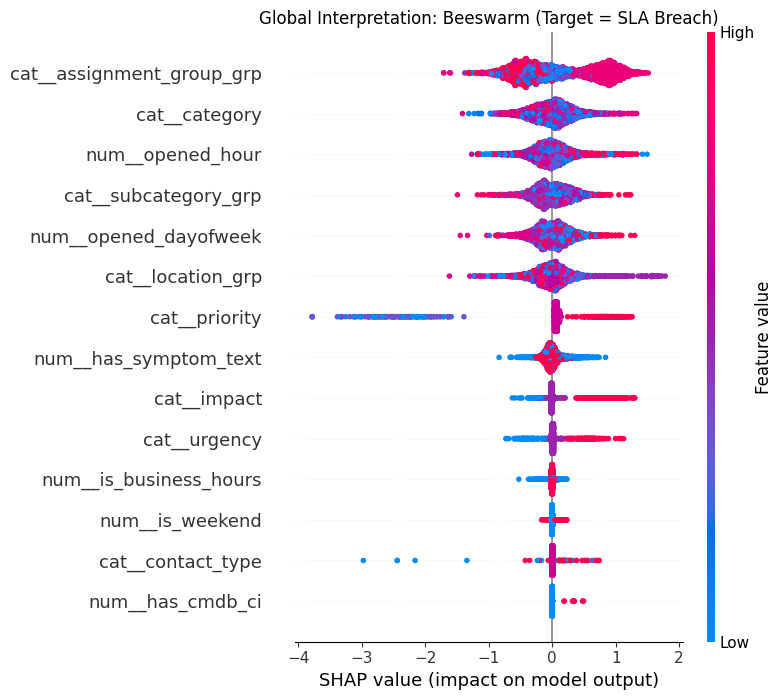

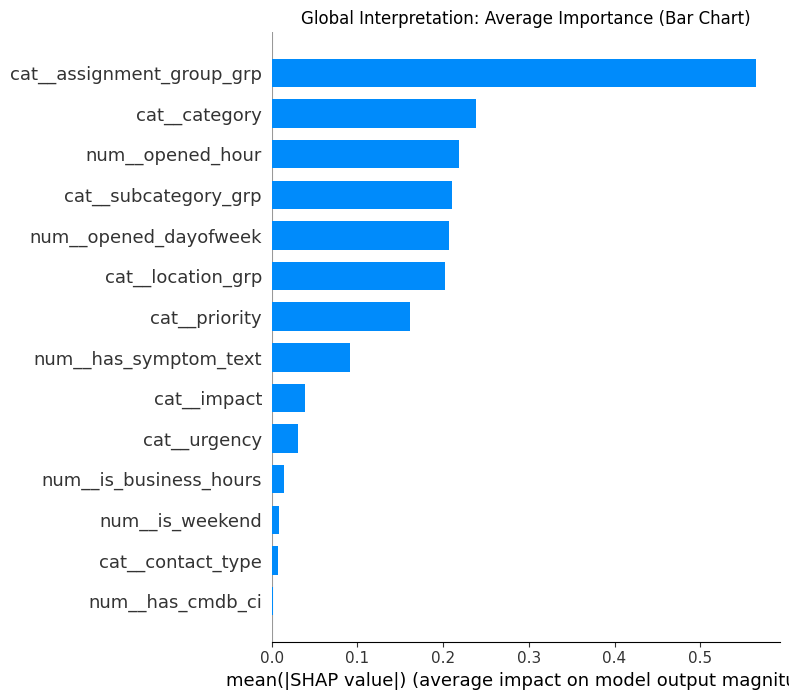

In [ ]:
#XGB beeswarm
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP PATHS
save_path = "/content/drive/MyDrive/Colab Notebooks/"
PREFIX = "2xgb2_"

# 2. LOAD THE ARTEFACTS (The files you saved earlier)
# Load the model pipeline
model_pipeline = joblib.load(f"{save_path}{PREFIX}xgb_best_pipeline_sklearn180.joblib")

# Load the test data and feature names
X_test_raw = pd.read_csv(f"{save_path}{PREFIX}X_test_for_shap.csv")
feature_names = pd.read_csv(f"{save_path}{PREFIX}xgb_feature_names.csv")['feature'].tolist()

# 3. PREPARE DATA
# Use the pipeline's preprocessor to transform the raw data into the 14 features
preprocessor = model_pipeline.named_steps['preprocessor']
X_test_transformed = preprocessor.transform(X_test_raw)
classifier = model_pipeline.named_steps['classifier']

# 4. CALCULATE SHAP VALUES
explainer = shap.TreeExplainer(classifier)
shap_values_all = explainer.shap_values(X_test_transformed)

# Select Class 0 ('False' / SLA Breach)
if isinstance(shap_values_all, list):
    shap_values_breach = shap_values_all[0]
else:
    shap_values_breach = shap_values_all

# --- 5. PLOT A: BEESWARM (Slide 12) ---
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_breach,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="dot",
    show=False
)
plt.title("Global Interpretation: Beeswarm (Target = SLA Breach)")
plt.tight_layout()
plt.savefig(f"{save_path}{PREFIX}beeswarm_synced.png")
plt.show()

# --- 6. PLOT B: BAR CHART (Slide 13) ---
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_breach,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title("Global Interpretation: Average Importance (Bar Chart)")
plt.tight_layout()
plt.savefig(f"{save_path}{PREFIX}bar_chart_synced.png")
plt.show()

In [ ]:
# 1. Calculate SHAP values for the first 200 records to create a searchable matrix
shap_values_matrix = explainer.shap_values(X_test_transformed[:200])

# 2. Automated Safety Check (Fixes the scalar/list error)
if isinstance(shap_values_matrix, list):
    # If SHAP gives a list [class0, class1], take class 0 ('False' / Breach)
    shap_values_target = shap_values_matrix[0]
    base_value_target = explainer.expected_value[0]
else:
    # If SHAP gives a single array, use it directly
    shap_values_target = shap_values_matrix
    # Check if expected_value is a list or a single number (scalar)
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value_target = explainer.expected_value[0]
    else:
        base_value_target = explainer.expected_value

print("✅ Step 1 Success: SHAP Matrix calculated and Baseline identified.")

✅ Step 1 Success: SHAP Matrix calculated and Baseline identified.


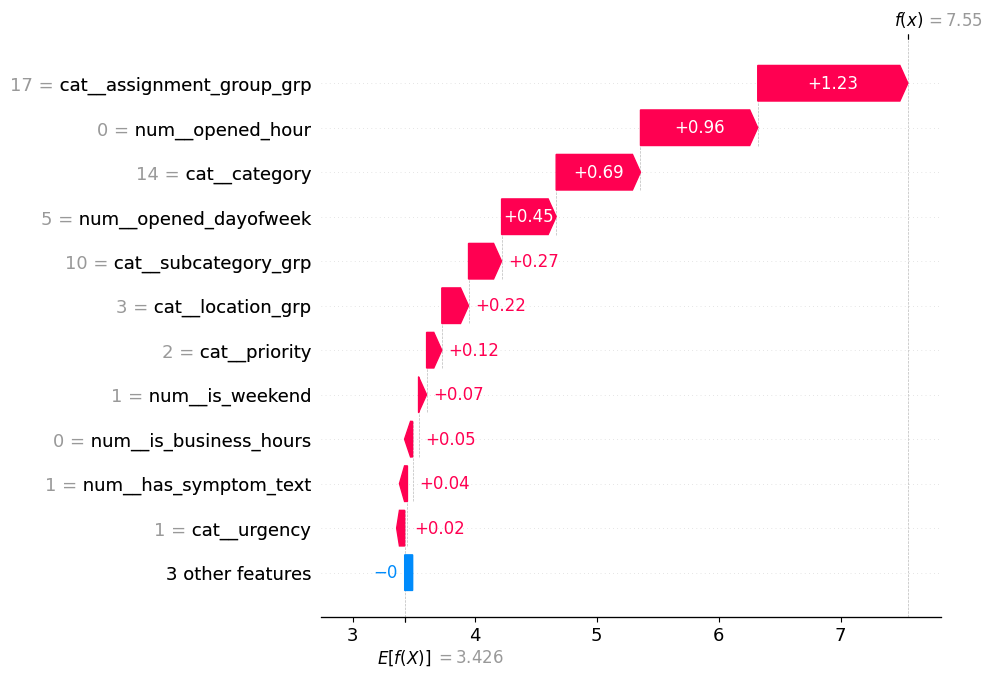

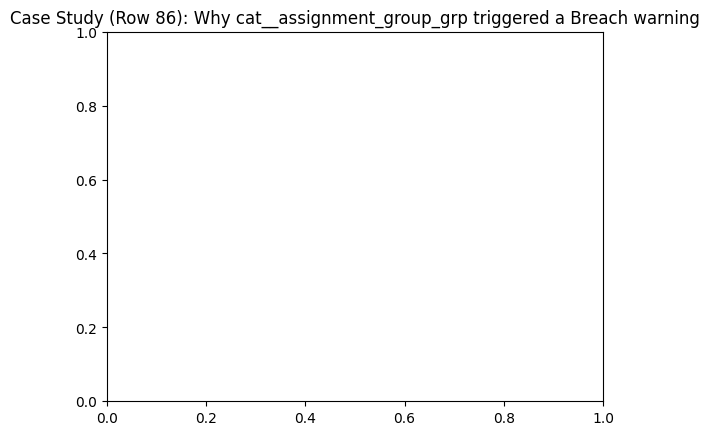

Showing Waterfall for Record Index: 86


In [ ]:
# --- 1. USER INPUT ---
# Use the exact name from your list earlier
target_feature = 'cat__assignment_group_grp'
pick_mode = "max_pos"

# --- 2. SELECTION LOGIC ---
feat_j = list(feature_names).index(target_feature)
shap_vals_for_feature = shap_values_target[:, feat_j]

# Find the row where this feature pushed the RISK highest (max_pos)
selected_i = np.argmax(shap_vals_for_feature)

# --- 3. GENERATE WATERFALL ---
exp = shap.Explanation(
    values=shap_values_target[selected_i],
    base_values=base_value_target,
    data=X_test_transformed[selected_i],
    feature_names=feature_names
)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(exp, max_display=12)
plt.title(f"Case Study (Row {selected_i}): Why {target_feature} triggered a Breach warning")
plt.show()

print(f"Showing Waterfall for Record Index: {selected_i}")

In [ ]:
import numpy as np

# 1. Get the SHAP values for your SELECTED row (selected_i)
# We use the same variables from your previous Waterfall cell
row_shap = shap_values_target[selected_i]
row_data = X_test_transformed[selected_i]

# 2. Match them to feature names and sort by absolute impact
# This is exactly how the school generates that list
indexed_features = []
for i in range(len(feature_names)):
    indexed_features.append({
        'name': feature_names[i],
        'shap': row_shap[i],
        'abs_shap': abs(row_shap[i])
    })

# Sort by absolute impact (highest magnitude first)
sorted_features = sorted(indexed_features, key=lambda x: x['abs_shap'], reverse=True)

# 3. PRINT THE OUTPUT (School Style)
print(f"--- LOCAL INTERPRETATION (Row {selected_i}) ---")
print(f"Baseline (Expected Value): {base_value_target:.4f}")
print(f"Chosen feature for selection: {target_feature}")
print(f"Feature SHAP at this row: {row_shap[list(feature_names).index(target_feature)]:.4f}")
print("\nTop contributors for this case (by |SHAP|):")

for feat in sorted_features[:12]: # Showing Top 12 like your school snippet
    direction = "pushes UP (Toward Breach)" if feat['shap'] > 0 else "pushes DOWN (Toward Success)"
    print(f"- {feat['name']:30s} SHAP= {feat['shap']:8.4f} ({direction})")

--- LOCAL INTERPRETATION (Row 86) ---
Baseline (Expected Value): 3.4258
Chosen feature for selection: cat__assignment_group_grp
Feature SHAP at this row: 1.2307

Top contributors for this case (by |SHAP|):
- cat__assignment_group_grp      SHAP=   1.2307 (pushes UP (Toward Breach))
- num__opened_hour               SHAP=   0.9612 (pushes UP (Toward Breach))
- cat__category                  SHAP=   0.6909 (pushes UP (Toward Breach))
- num__opened_dayofweek          SHAP=   0.4474 (pushes UP (Toward Breach))
- cat__subcategory_grp           SHAP=   0.2709 (pushes UP (Toward Breach))
- cat__location_grp              SHAP=   0.2191 (pushes UP (Toward Breach))
- cat__priority                  SHAP=   0.1247 (pushes UP (Toward Breach))
- num__is_weekend                SHAP=   0.0660 (pushes UP (Toward Breach))
- num__is_business_hours         SHAP=   0.0491 (pushes UP (Toward Breach))
- num__has_symptom_text          SHAP=   0.0419 (pushes UP (Toward Breach))
- cat__urgency                   S

In [ ]:
#The Comparison Cell (pFI vs. SHAP)
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, matthews_corrcoef
import pandas as pd
import numpy as np

# 1. Setup the Scorer (School Standard: MCC)
mcc_scorer = make_scorer(matthews_corrcoef)

# 2. Run pFI on the FULL pipeline
# We use 'model_pipeline' and the raw 'X_test_raw' you loaded earlier
print("Calculating Permutation Importance (this may take a moment)...")
pfi_xgb = permutation_importance(
    estimator=model_pipeline,   # Your Stage 2 Pipeline
    X=X_test_raw,               # Use the RAW test data (pre-transformation)
    y=y_test,                   # Your true labels
    scoring=mcc_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 3. Create Series for pFI (Raw Columns)
pfi_series = pd.Series(
    pfi_xgb.importances_mean,
    index=X_test_raw.columns
).sort_values(ascending=False)

# 4. Create Series for SHAP (Transformed Features)
# Using 'shap_values_breach' from your Beeswarm cell
shap_global = pd.Series(
    np.abs(shap_values_breach).mean(axis=0),
    index=feature_names
).sort_values(ascending=False)

# 5. DISPLAY RESULTS
print("\n--- TOP RAW-COLUMN pFI ---")
print("(Which column hurts MCC score the most if shuffled?)")
print(pfi_series.head(10))

print("\n--- TOP TRANSFORMED-FEATURE SHAP ---")
print("(Which specific feature pushes individual predictions most?)")
print(shap_global.head(10))

# 6. SAVE FOR PROJECT EVIDENCE
pfi_series.to_csv(f"{save_path}{PREFIX}pfi_results.csv")


Calculating Permutation Importance (this may take a moment)...

--- TOP RAW-COLUMN pFI ---
(Which column hurts MCC score the most if shuffled?)
priority                0.148419
opened_hour             0.034978
assignment_group_grp    0.025915
subcategory_grp         0.024141
urgency                 0.021031
opened_dayofweek        0.019291
category                0.019081
location_grp            0.014386
has_symptom_text        0.012854
contact_type            0.008286
dtype: float64

--- TOP TRANSFORMED-FEATURE SHAP ---
(Which specific feature pushes individual predictions most?)
cat__assignment_group_grp    0.564857
cat__category                0.238201
num__opened_hour             0.218697
cat__subcategory_grp         0.210737
num__opened_dayofweek        0.207230
cat__location_grp            0.201765
cat__priority                0.160886
num__has_symptom_text        0.091758
cat__impact                  0.038967
cat__urgency                 0.031166
dtype: float32


In [ ]:
import numpy as np

# Mapping your variables to the school's standard names
shap_xgb_c1 = shap_values_breach
X_test_xgb = X_test_transformed
xgb_feature_names = feature_names

# Mean absolute SHAP per feature
mean_abs_shap = np.abs(shap_xgb_c1).mean(axis=0)

# Sort feature indices by impact (descending)
order = np.argsort(mean_abs_shap)[::-1]

# Sorted feature names (most impactful first)
xgb_feature_names_sorted = [xgb_feature_names[i] for i in order]

# Preview top features (Identical to your school code #2)
print("Top SHAP features:")
for name, val in zip(xgb_feature_names_sorted[:10], mean_abs_shap[order][:10]):
    print(f"{name:30s}  mean|SHAP| = {val:.4f}")

Top SHAP features:
cat__assignment_group_grp       mean|SHAP| = 0.5649
cat__category                   mean|SHAP| = 0.2382
num__opened_hour                mean|SHAP| = 0.2187
cat__subcategory_grp            mean|SHAP| = 0.2107
num__opened_dayofweek           mean|SHAP| = 0.2072
cat__location_grp               mean|SHAP| = 0.2018
cat__priority                   mean|SHAP| = 0.1609
num__has_symptom_text           mean|SHAP| = 0.0918
cat__impact                     mean|SHAP| = 0.0390
cat__urgency                    mean|SHAP| = 0.0312


In [ ]:
# 1. Map variables to school style
shap_xgb_c1 = shap_values_breach
X_test_xgb = X_test_transformed
xgb_feature_names = feature_names

# 2. Rank and Preview
mean_abs_shap = np.abs(shap_xgb_c1).mean(axis=0)
order = np.argsort(mean_abs_shap)[::-1]
xgb_feature_names_sorted = [xgb_feature_names[i] for i in order]

print("Top SHAP features:")
for name, val in zip(xgb_feature_names_sorted[:10], mean_abs_shap[order][:10]):
    print(f"{name:30s}  mean|SHAP| = {val:.4f}")

Top SHAP features:
cat__assignment_group_grp       mean|SHAP| = 0.5649
cat__category                   mean|SHAP| = 0.2382
num__opened_hour                mean|SHAP| = 0.2187
cat__subcategory_grp            mean|SHAP| = 0.2107
num__opened_dayofweek           mean|SHAP| = 0.2072
cat__location_grp               mean|SHAP| = 0.2018
cat__priority                   mean|SHAP| = 0.1609
num__has_symptom_text           mean|SHAP| = 0.0918
cat__impact                     mean|SHAP| = 0.0390
cat__urgency                    mean|SHAP| = 0.0312


In [ ]:
# #Directional insight: dependence plots
# # Pick a feature by name (Identical to your school code #3)
# # Try changing the index 0 to 1, 2, or 3 to see different trends
# feature_name = xgb_feature_names_sorted[0]
# print("Using feature:", feature_name)

# plt.figure(figsize=(8, 5))
# shap.dependence_plot(
#     feature_name,
#     shap_xgb_c1,
#     X_test_xgb,
#     feature_names=xgb_feature_names,
#     interaction_index=None,    # <-- removes color dimension as per your school notes
#     show=False
# )

# plt.title(f"Directional Insight: {feature_name}")
# plt.axhline(0, color='red', linestyle='--', alpha=0.3) # Adds a 'Baseline' reference line
# plt.tight_layout()

# # Save for Slide 14
# filename = f"{save_path}{PREFIX}dependence_{feature_name}.png"
# plt.savefig(filename)
# plt.show()

Using feature: cat__assignment_group_grp


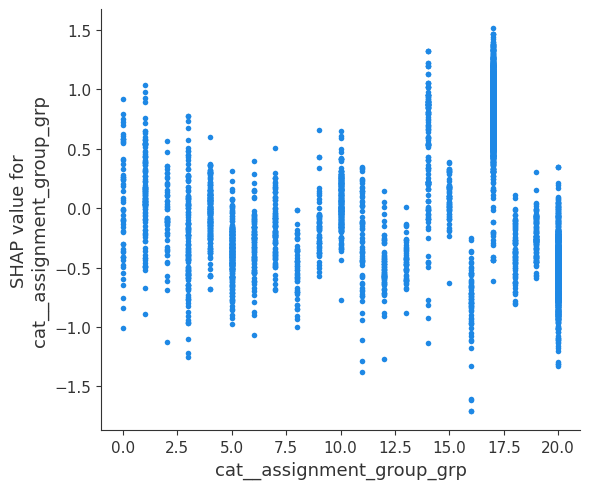

In [ ]:
feature_name = xgb_feature_names_sorted[0]
print("Using feature:", feature_name)

shap.dependence_plot(
    feature_name,
    shap_xgb_c1,
    X_test_xgb,
    feature_names=xgb_feature_names,
    interaction_index=None,
    show=False
)
plt.tight_layout()
plt.show()

Generating plot for Rank 1: cat__assignment_group_grp


<Figure size 800x500 with 0 Axes>

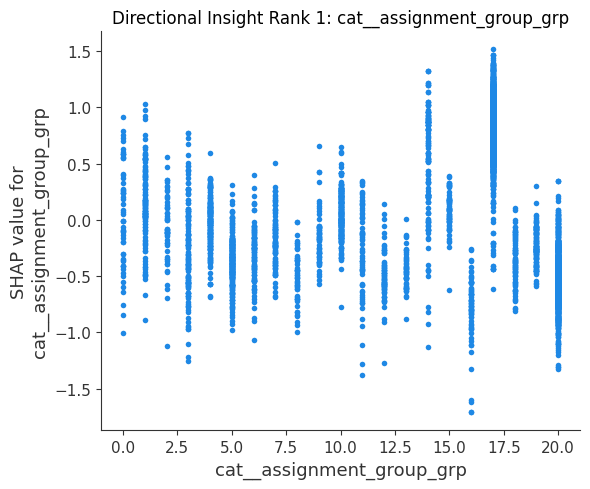

Generating plot for Rank 2: cat__category


<Figure size 800x500 with 0 Axes>

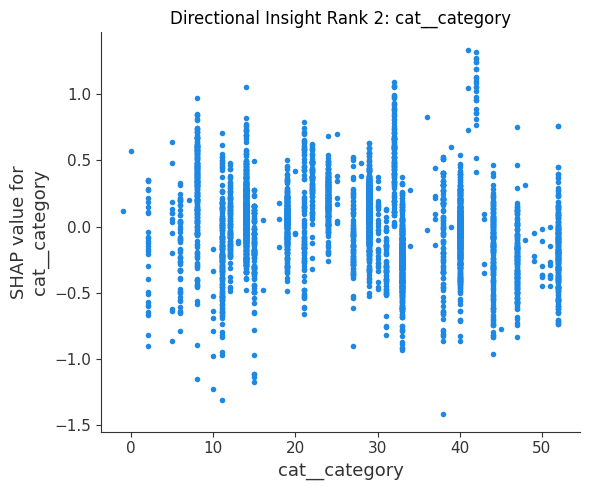

Generating plot for Rank 3: num__opened_hour


<Figure size 800x500 with 0 Axes>

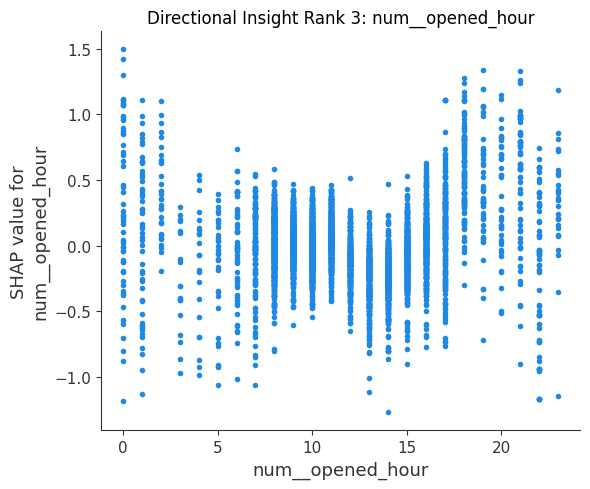

Generating plot for Rank 4: cat__subcategory_grp


<Figure size 800x500 with 0 Axes>

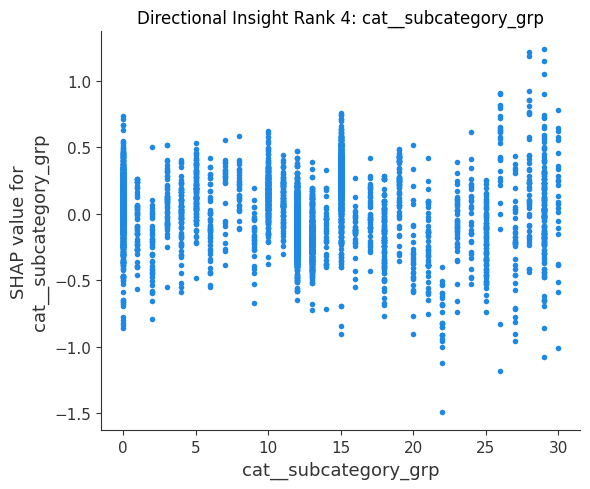

Generating plot for Rank 5: num__opened_dayofweek


<Figure size 800x500 with 0 Axes>

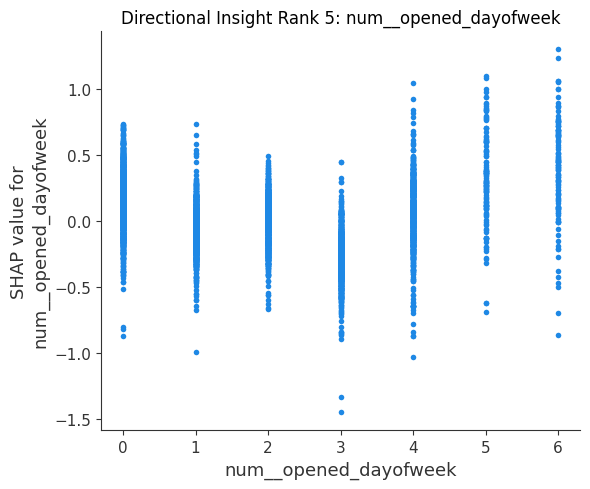

In [ ]:
# Following your school code logic but in a loop for the Top 5
for i in range(5):
    feature_name = xgb_feature_names_sorted[i]
    print(f"Generating plot for Rank {i+1}: {feature_name}")

    plt.figure(figsize=(8, 5))
    shap.dependence_plot(
        feature_name,
        shap_xgb_c1,
        X_test_xgb,
        feature_names=xgb_feature_names,
        interaction_index=None,
        show=False
    )
    plt.title(f"Directional Insight Rank {i+1}: {feature_name}")
    plt.tight_layout()

    # Save each one so you can just drag them into your PowerPoint
    plt.savefig(f"{save_path}{PREFIX}dependence_rank_{i+1}.png")
    plt.show()

In [ ]:
#Wrap-up prompts (write-up practice)
import numpy as np
import pandas as pd

def summarise_dependence_as_text(
    feature_name: str,
    shap_values_2d,          # shap_xgb_c1
    X_2d,                    # X_test_xgb
    feature_names: list,
    critical_q=0.90,         # top 10% by |SHAP|
    bins=10
):
    j = feature_names.index(feature_name)
    x = np.asarray(X_2d)[:, j]
    s = np.asarray(shap_values_2d)[:, j]

    # 1) Direction (simple correlation as a sign)
    corr = np.corrcoef(x, s)[0, 1]
    direction = "increases" if corr > 0 else "decreases"

    # 2) Turning point (approx where SHAP crosses 0)
    sign_change = np.where(np.sign(s[:-1]) != np.sign(s[1:]))[0]
    if len(sign_change) > 0:
        k = sign_change[np.argmin(np.abs(s[sign_change]))]
        turning_point = float(np.mean([x[k], x[k+1]]))
        turning_note = f"SHAP crosses 0 around x ≈ {turning_point:.3f}."
    else:
        turning_note = "SHAP does not clearly cross 0 in this sample (mostly one-sided impact)."

    # 3) Critical zone by |SHAP|
    thr = float(np.quantile(np.abs(s), critical_q))
    mask = np.abs(s) >= thr
    if mask.any():
        crit_min = float(np.min(x[mask]))
        crit_max = float(np.max(x[mask]))
        crit_note = (
            f"Critical impact (top {int((1-critical_q)*100)}% by |SHAP|): "
            f"|SHAP| ≥ {thr:.3f} occurs when x is roughly in [{crit_min:.3f}, {crit_max:.3f}]."
        )
    else:
        crit_note = "No points exceed the chosen critical threshold."

    # 4) Magnitude
    mean_abs = float(np.mean(np.abs(s)))
    max_abs  = float(np.max(np.abs(s)))
    mag_note = f"Average |SHAP| ≈ {mean_abs:.3f}; max |SHAP| ≈ {max_abs:.3f}."

    # 5) Binned trend
    qs = np.quantile(x, np.linspace(0, 1, bins + 1))
    qs = np.unique(qs)
    if len(qs) >= 3:
        bin_ids = np.digitize(x, qs[1:-1], right=True)
        bin_summary = []
        for b in range(bin_ids.min(), bin_ids.max() + 1):
            xb = x[bin_ids == b]
            sb = s[bin_ids == b]
            if len(xb) == 0: continue
            bin_summary.append({
                "x_range": f"[{np.min(xb):.3f}, {np.max(xb):.3f}]",
                "mean_abs_shap": float(np.mean(np.abs(sb)))
            })
        bin_df = pd.DataFrame(bin_summary).sort_values("mean_abs_shap", ascending=False)
        top_bins = bin_df.head(3)
        bins_note = "Most impactful value ranges:\n" + top_bins.to_string(index=False)
    else:
        bins_note = "Binned trend unavailable."

    return (f"Dependence summary for feature: {feature_name}\n"
            f"- Trend: {direction}\n- {turning_note}\n- {crit_note}\n- {mag_note}\n- {bins_note}\n")

In [ ]:
#Step 2, 3 & 4: Gathering Evidence & Payload
# --- STEP 2: Find Top 8 ---
TOP_N = 8
mean_abs_shap = np.abs(shap_xgb_c1).mean(axis=0)
order = np.argsort(mean_abs_shap)[::-1]
top_feature_names = [xgb_feature_names[i] for i in order[:TOP_N]]

# --- STEP 3: Summarize each feature ---
dependence_summaries = []
for fname in top_feature_names:
    txt = summarise_dependence_as_text(
        feature_name=fname,
        shap_values_2d=shap_xgb_c1,
        X_2d=X_test_xgb,
        feature_names=xgb_feature_names
    )
    dependence_summaries.append(txt)

# --- STEP 4: Build the LLM Payload ---
payload_text = f"""
You are supporting decision-making for Sam (Ops Manager) using a trained XGBoost model.

CONTEXT:
- Interpretations are SHAP-based (association, not causation).
- The goal is to reduce SLA Breaches.

TASK:
1) Give 3 data-driven recommendations referencing at least TWO features each.
2) State one risk/limitation per recommendation.
3) Propose 2 monitoring checks for drift.

FEATURE-LEVEL EVIDENCE:
{"\n\n".join(dependence_summaries)}
""".strip()

print(payload_text)

You are supporting decision-making for Sam (Ops Manager) using a trained XGBoost model.

CONTEXT:
- Interpretations are SHAP-based (association, not causation).
- The goal is to reduce SLA Breaches.

TASK:
1) Give 3 data-driven recommendations referencing at least TWO features each.
2) State one risk/limitation per recommendation.
3) Propose 2 monitoring checks for drift.

FEATURE-LEVEL EVIDENCE:
Dependence summary for feature: cat__assignment_group_grp
- Trend: increases
- SHAP crosses 0 around x ≈ 20.000.
- Critical impact (top 9% by |SHAP|): |SHAP| ≥ 1.005 occurs when x is roughly in [0.000, 20.000].
- Average |SHAP| ≈ 0.565; max |SHAP| ≈ 1.710.
- Most impactful value ranges:
         x_range  mean_abs_shap
[13.000, 17.000]       0.797483
[18.000, 20.000]       0.487284
  [5.000, 7.000]       0.337438


Dependence summary for feature: cat__category
- Trend: decreases
- SHAP crosses 0 around x ≈ 26.000.
- Critical impact (top 9% by |SHAP|): |SHAP| ≥ 0.498 occurs when x is roughly in 

In [ ]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [ ]:
response = client.responses.create(
    model="gpt-5-mini", # or your available model
    instructions="""
You are an expert Data Scientist and IT Operations Consultant.
You specialize in tree-based models and SHAP explanations for Service Management.
You must reason strictly from the provided SHAP evidence and IT service context.
You should draw reasonable conclusions about operational efficiency and SLA risks.
""",
    input=f"""
Dataset context:
- Dataset: IT Service Management (SLA Performance Data)
- Task: Binary classification (SLA Met vs SLA Breach)
- Model: Stage 2 XGBoost (Optimized with MCC)
- Interpretation method: SHAP (model-driven, log-odds scale)

Model interpretation evidence:
{payload_text}

Questions:

1. From an IT Operations perspective, how should recommendations be formed when using this model to support Service Desk managers?

2. Based on the SHAP evidence across the top features, identify the strongest combined risk patterns (e.g., specific Groups + Time of Day) the model uses for prediction. Highlight patterns where data might be scarce or risk is highest.

3. Propose 3 data-driven recommendations that Sam (the Ops Manager) could reasonably implement using this model output to reduce breaches.

4. Suggest 2 post-deployment monitoring checks to ensure these SHAP-based patterns (like Group 17 performance) remain stable and operationally sensible over time.

Rules:
- Use professional IT Management language (SLA, Handover, Backlog, Staffing).
- Treat the model as a 'Decision Support' tool for humans, not an automated decider.
- Base all reasoning strictly on the SHAP evidence provided in the payload.
"""
)

print(response.output_text)

Summary guidance (how to form recommendations from this SHAP-driven model)
- Treat the XGBoost + SHAP output as decision-support: use SHAP to prioritize where to investigate and intervene, not to automatically reassign tickets.
- Form recommendations around combinations of high-SHAP features (assignment group, time-of-day/day-of-week, priority, category/subcategory, location, presence of symptom text). Use the sign/trend information (where provided) to decide whether a feature value is associated with higher predicted breach risk or lower predicted risk, and always validate operationally with owners of the affected groups.
- For operational actions, require a short human validation step before changing staffing/handover: map numeric codes to real assignment groups/categories, confirm sample sizes for the flagged ranges, and run a quick root-cause check (backlog, handover, missing information) before executing changes.

1) Strongest combined risk patterns the model is using (based stric

In [ ]:
# import os
# import json
# import joblib
# import pandas as pd
# from sklearn.metrics import matthews_corrcoef

# # 1. Configuration - Direct Drive Path
# PREFIX = "2xgb2_"
# save_path = "/content/drive/MyDrive/Colab Notebooks/"

# # Ensure the directory exists (just in case)
# os.makedirs(save_path, exist_ok=True)

# # 2. Pick your Winner
# # Ensure 'gs_xgb_s2' matches your Stage 2 GridSearchCV variable name
# target_model = gs_xgb_s2.best_estimator_

# # 3. Save the Pipeline (The 'Brain')
# joblib.dump(target_model, f"{save_path}{PREFIX}best_pipeline.joblib")

# # 4. Save Background Sample (The 'Baseline' for SHAP)
# RANDOM_STATE = 42
# BG_N = 300
# X_train_df = X_train.copy() if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train)

# X_bg = X_train_df.sample(n=min(BG_N, len(X_train_df)), random_state=RANDOM_STATE)
# X_bg.to_csv(f"{save_path}{PREFIX}X_background.csv", index=False)

# # 5. Save Feature Names (The 'Labels' for Plots)
# pre = target_model.named_steps.get("preprocessor", None)
# if pre is not None:
#     feature_names = pre.get_feature_names_out()
#     pd.Series(feature_names, name="feature").to_csv(
#         f"{save_path}{PREFIX}feature_names.csv", index=False
#     )

# # 6. Save Test Data & Indices
# X_test_df = X_test.copy() if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test)
# X_test_df.to_csv(f"{save_path}{PREFIX}X_test_for_shap.csv", index=False)

# pd.Series(X_test_df.index, name="test_idx").to_csv(
#     f"{save_path}{PREFIX}test_idx.csv", index=False
# )

# # 7. Save Library Versions
# import sklearn, shap, xgboost
# versions = {
#     "sklearn": sklearn.__version__,
#     "xgboost": xgboost.__version__,
#     "shap": shap.__version__
# }
# with open(f"{save_path}{PREFIX}VERSIONS.json", "w") as f:
#     json.dump(versions, f, indent=2)

# print(f"✅ Success! Files saved with prefix '{PREFIX}' in: {save_path}")

✅ Success! Files saved with prefix '2xgb2_' in: /content/drive/MyDrive/Colab Notebooks/


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# # Create the path if it doesn't exist
# save_path = "/content/drive/MyDrive/Colab Notebooks/"
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
